In [1]:
# (UCL=UPPER CONTROL LIMITS)

### Imports

In [2]:
# libraries importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import math

# additional modules
import sys
import time

from IPython.display import display, HTML
from IPython.display import clear_output

sys.path.append('../utils')

import numpy as np
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization 
from tensorflow.keras.layers import  Activation, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM, RepeatVector, Flatten, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product



from tqdm import tqdm

In [3]:
import basemodels
import anomalyutils
import utils

### Random Function

In [4]:
utils.set_random(0)

### Load Data

In [20]:
# benchmark files checking
all_files = utils.get_files()
# datasets with anomalies loading
list_of_df = utils.get_anomaly_data()
# anomaly-free df loading
anomaly_free_df = utils.get_anomaly_free_data()

In [26]:
for i in list_of_df:
    print(round((len(i)-600)/len(i)*100,1), end=" - ")

19.5 - 54.8 - 49.6 - 42.7 - 35.0 - 33.7 - 23.1 - 47.2 - 49.6 - 48.1 - 47.7 - 45.0 - 47.7 - 47.6 - 47.7 - 47.6 - 47.6 - 47.4 - 47.4 - 47.4 - 47.3 - 47.8 - 44.2 - 47.7 - 45.2 - 48.0 - 48.0 - 45.2 - 47.6 - 47.7 - 46.7 - 43.6 - 46.9 - 39.7 - 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Main Run Loop

In [28]:
%%time

X_conv_ae_window = 60
final_aggr_pd = None
start_of_loop = time.perf_counter()
times_of_ds = []
for df_index, df in enumerate(list_of_df):
    
    start_ds = time.perf_counter()

    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    X_ae = StSc.transform(X_train)
    X_conv_ae = utils.create_sequences(StSc.transform(X_train), X_conv_ae_window)
    X_lstm, y_lstm = utils.split_sequences(StSc.transform(X_train), 5)
    X_lstm_ae = utils.create_sequences(StSc.transform(X_train), 10)
    X_lstm_vae = utils.create_sequences(StSc.transform(X_train), 5)

    # model defining and fitting
    
    autoencoder_model = basemodels.autoencoder(X_ae)
    conv_ae_model = basemodels.conv_ae(X_conv_ae)
    lstm_model = basemodels.lstm(X_lstm, y_lstm)
    lstm_ae_model = basemodels.lstm_ae(X_lstm_ae)
    lstm_vae_model = basemodels.lstm_vae(X_lstm_vae)

    lstm_model.load_weights("lstm.h5")
    
    predictions_ae = anomalyutils.get_ae_predicts(autoencoder_model, X_ae)
    predictions_conv_ae = anomalyutils.get_conv_ae_predicts(conv_ae_model, X_conv_ae)
    predictions_lstm = anomalyutils.get_lstm_predicts(lstm_model, X_lstm)
    predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(lstm_ae_model, X_lstm_ae)
    predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(lstm_vae_model, X_lstm_vae)

    residuals_autoencoder = anomalyutils.get_ae_residuals(X_ae, predictions_ae)
    residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
    residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
    residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
    residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)

    UCL_autoencoder = residuals_autoencoder.quantile(0.99)
    UCL_conv_ae = residuals_conv_ae.quantile(0.999)
    UCL_lstm = residuals_lstm.quantile(0.99)
    UCL_lstm_ae = residuals_lstm_ae.quantile(0.99)
    UCL_lstm_vae = residuals_lstm_vae.quantile(0.999)

    X_all = df.drop(['anomaly','changepoint'], axis=1)
    X_ae = StSc.transform(X_all)
    X_conv_ae = utils.create_sequences(StSc.transform(X_all), X_conv_ae_window)
    X_lstm, y_lstm = utils.split_sequences(StSc.transform(X_all), 5)
    X_lstm_ae = utils.create_sequences(StSc.transform(X_all), 10)
    X_lstm_vae = utils.create_sequences(StSc.transform(X_all), 5)
    
    predictions_ae = anomalyutils.get_ae_predicts(autoencoder_model, X_ae)
    predictions_conv_ae = anomalyutils.get_conv_ae_predicts(conv_ae_model, X_conv_ae)
    predictions_lstm = anomalyutils.get_lstm_predicts(lstm_model, X_lstm)
    predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(lstm_ae_model, X_lstm_ae)
    predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(lstm_vae_model, X_lstm_vae)

    residuals_autoencoder = anomalyutils.get_ae_residuals(X_ae, predictions_ae)
    residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
    residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
    residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
    residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)
    
    prediction_labels_autoencoder = pd.DataFrame(pd.Series((residuals_autoencoder > 3/2*UCL_autoencoder).astype(int).values, index=df.index).fillna(0))
    prediction_labels_conv_ae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_conv_ae, residuals_conv_ae, X_conv_ae_window, UCL_conv_ae, df.index))
    prediction_labels_lstm = pd.DataFrame(pd.Series((residuals_lstm>3/2*UCL_lstm).astype(int).values, index=df[5:].index).fillna(0))
    prediction_labels_lstm_ae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_lstm_ae, residuals_lstm_ae, 10, UCL_lstm_ae, df.index))
    prediction_labels_lstm_vae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_lstm_vae, residuals_lstm_vae, 5, UCL_lstm_vae, df.index))

    prediction_labels_autoencoder = prediction_labels_autoencoder.rename(columns={0:"anomaly_by_autoencoder"})
    prediction_labels_conv_ae = prediction_labels_conv_ae.rename(columns={0:"anomaly_by_conv_ae"})
    prediction_labels_lstm = prediction_labels_lstm.rename(columns={0:"anomaly_by_lstm"})
    prediction_labels_lstm_ae = prediction_labels_lstm_ae.rename(columns={0:"anomaly_by_lstm_ae"})
    prediction_labels_lstm_vae = prediction_labels_lstm_vae.rename(columns={0:"anomaly_by_lstm_vae"})
    
    voting_prediction = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
    voting_prediction = voting_prediction.join(prediction_labels_autoencoder)
    voting_prediction = voting_prediction.join(prediction_labels_conv_ae)
    voting_prediction = voting_prediction.join(prediction_labels_lstm)
    voting_prediction = voting_prediction.join(prediction_labels_lstm_ae)
    voting_prediction = voting_prediction.join(prediction_labels_lstm_vae)
    voting_prediction = voting_prediction.fillna(0)
    voting_prediction['anomaly_by_autoencoder'] = np.where(voting_prediction['anomaly_by_autoencoder'] == 1 , 1, -1)
    voting_prediction['anomaly_by_conv_ae'] = np.where(voting_prediction['anomaly_by_conv_ae'] == 1 , 1, -1)
    voting_prediction['anomaly_by_lstm'] = np.where(voting_prediction['anomaly_by_lstm'] == 1 , 1, -1)
    voting_prediction['anomaly_by_lstm_ae'] = np.where(voting_prediction['anomaly_by_lstm_ae'] == 1 , 1, -1)
    voting_prediction['anomaly_by_lstm_vae'] = np.where(voting_prediction['anomaly_by_lstm_vae'] == 1 , 1, -1)
    voting_prediction["anomaly_by_voting"] = voting_prediction['anomaly_by_autoencoder']\
        + voting_prediction['anomaly_by_conv_ae'] + voting_prediction['anomaly_by_lstm'] \
            + voting_prediction['anomaly_by_lstm_ae'] + voting_prediction['anomaly_by_lstm_vae']

    voting_prediction['anomaly_by_autoencoder'] = np.where(voting_prediction['anomaly_by_autoencoder'] == 1 , 1, 0)
    voting_prediction['anomaly_by_conv_ae'] = np.where(voting_prediction['anomaly_by_conv_ae'] == 1 , 1, 0)
    voting_prediction['anomaly_by_lstm'] = np.where(voting_prediction['anomaly_by_lstm'] == 1 , 1, 0)
    voting_prediction['anomaly_by_lstm_ae'] = np.where(voting_prediction['anomaly_by_lstm_ae'] == 1 , 1, 0)
    voting_prediction['anomaly_by_lstm_vae'] = np.where(voting_prediction['anomaly_by_lstm_vae'] == 1 , 1, 0)
    voting_prediction["anomaly_by_voting"] = np.where(voting_prediction['anomaly_by_voting'] < 0 , 0, 1)

    cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae", "anomaly_by_voting"]
    save_path =f"./images/{df_index}.png"
    utils.plot_confusion_matrix_all(voting_prediction, "anomaly" , *cols, save_image=save_path)
    
    final_aggr_pd = pd.concat([final_aggr_pd, voting_prediction], ignore_index=True)

    end_ds = time.perf_counter()

    print(end_ds-start_ds)
    times_of_ds.append(end_ds-start_ds)
end_of_loop = time.perf_counter()

for i in range(0,len(times_of_ds)):
    print(f"{i}){times_of_ds[i]}")
print(end_of_loop-start_of_loop)

24/24 [==============================] - 0s 2ms/step
45.25308629999927
CPU times: total: 1min 10s
Wall time: 45.3 s


### Summary

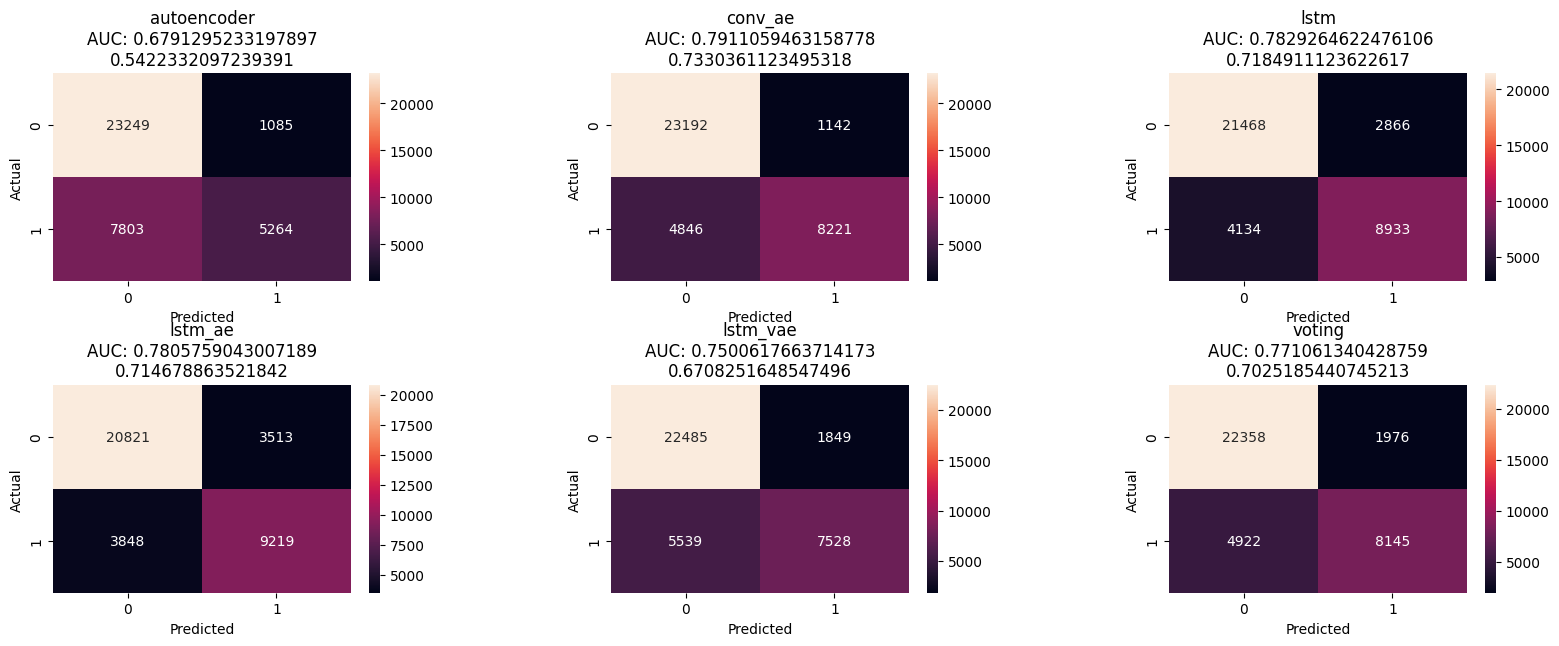

In [ ]:
cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae", "anomaly_by_voting"]
utils.plot_confusion_matrix_all(final_aggr_pd, "anomaly", *cols)

C:\Users\anastasis\AppData\Local\Temp\ipykernel_13472\1886792940.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,filename,image,image_A_1,image_A_2,image_A_3,image_A_4
0,./images/0.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
1,./images/1.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
2,./images/2.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
3,./images/3.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
4,./images/4.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
5,./images/5.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
6,./images/6.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
7,./images/7.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
8,./images/8.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd
9,./images/9.png,,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd,jasdjhasjdhjashdjhasd

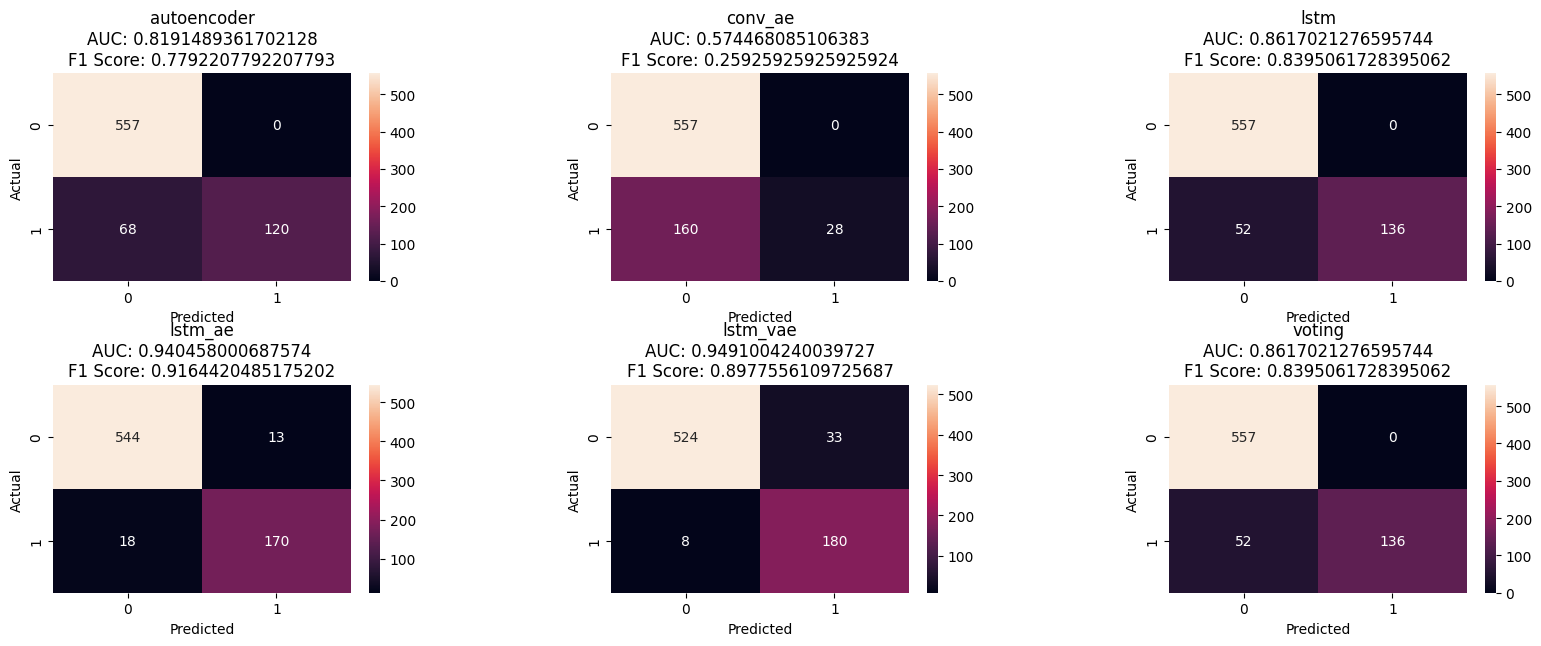
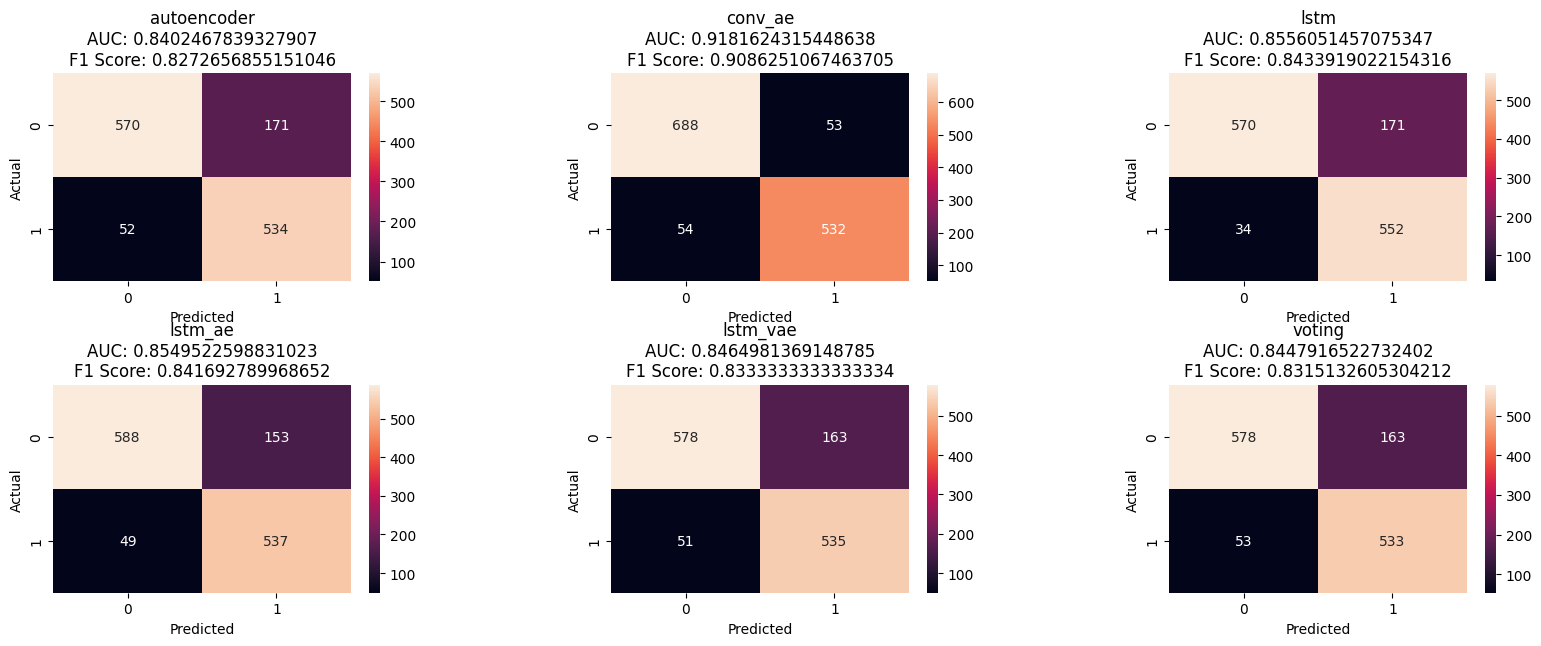
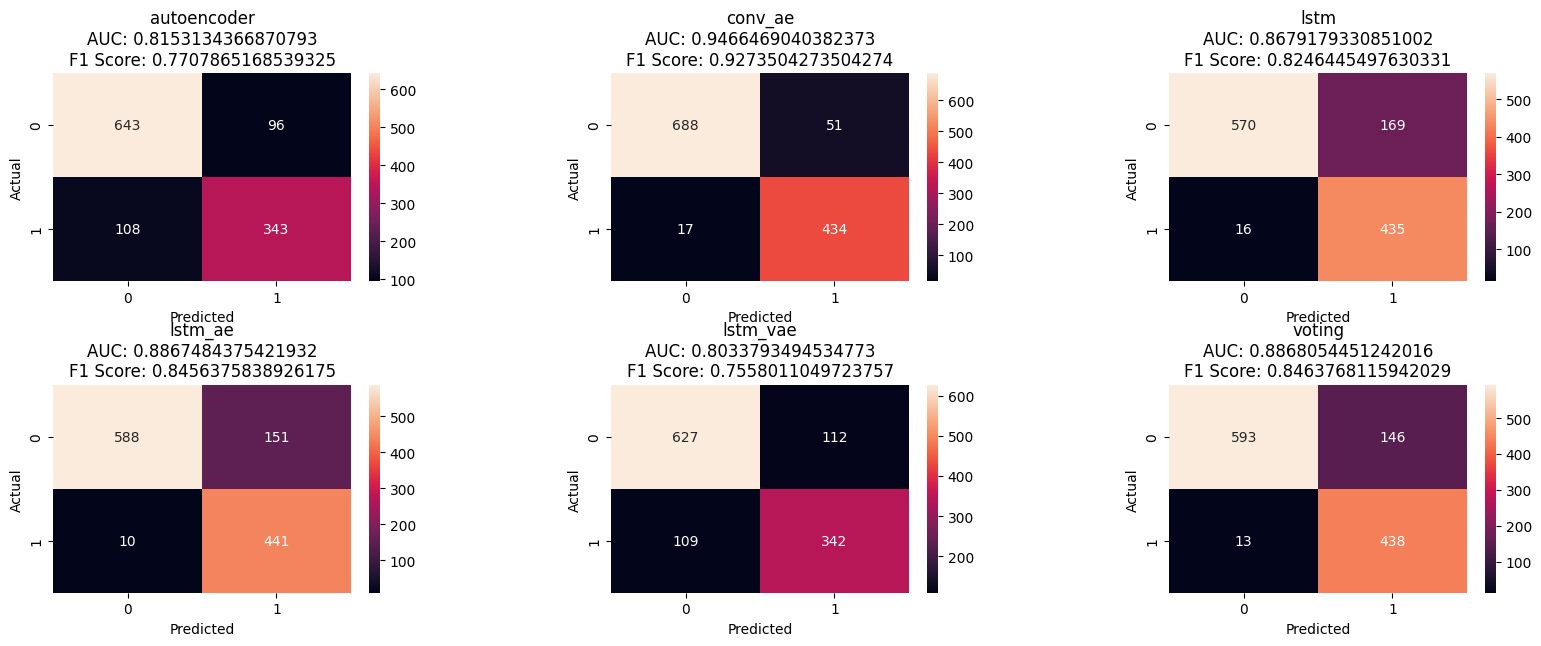
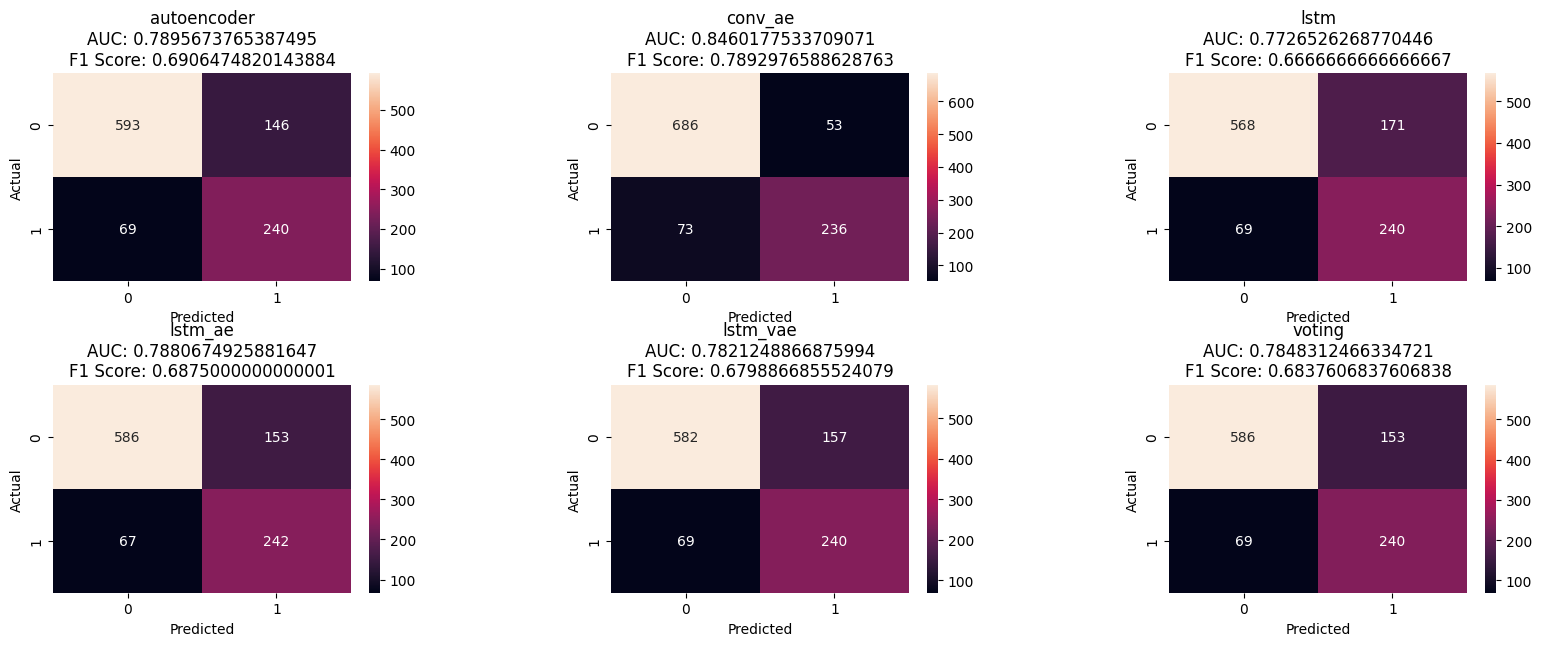
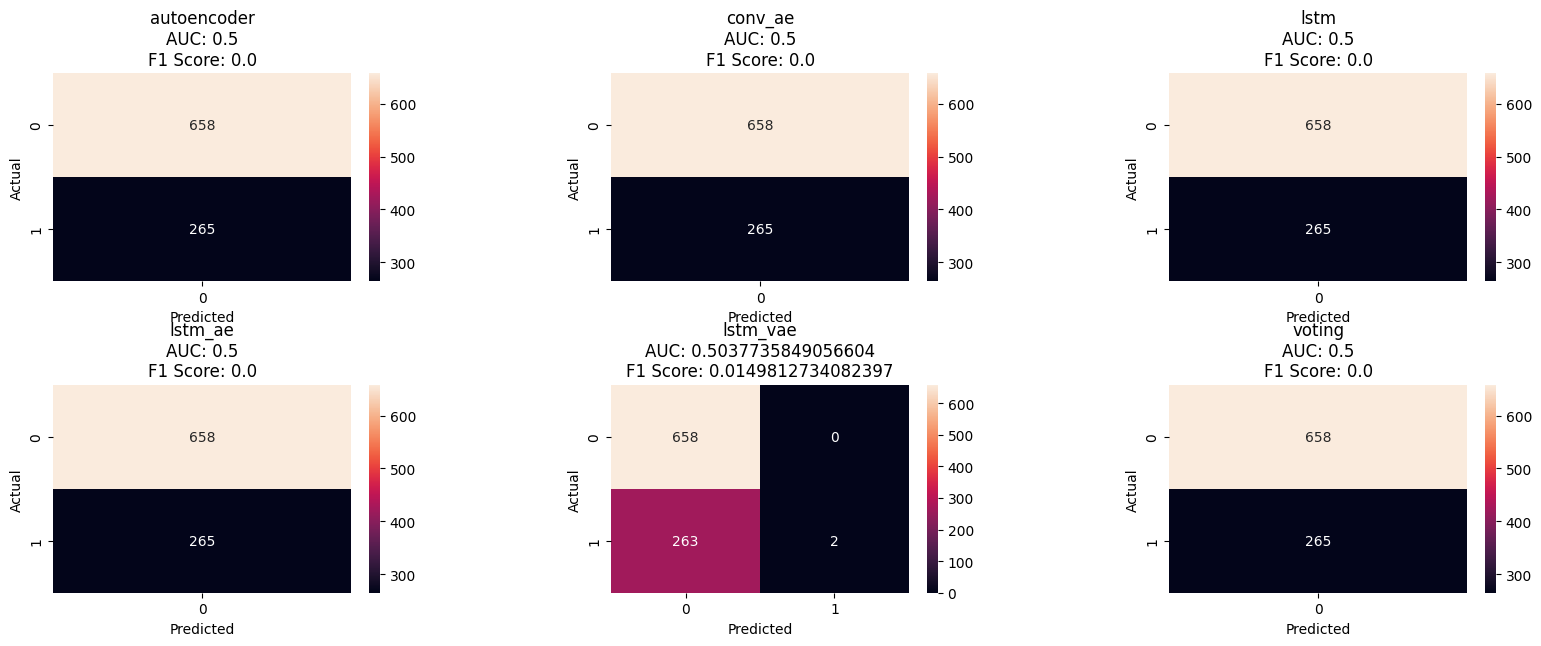
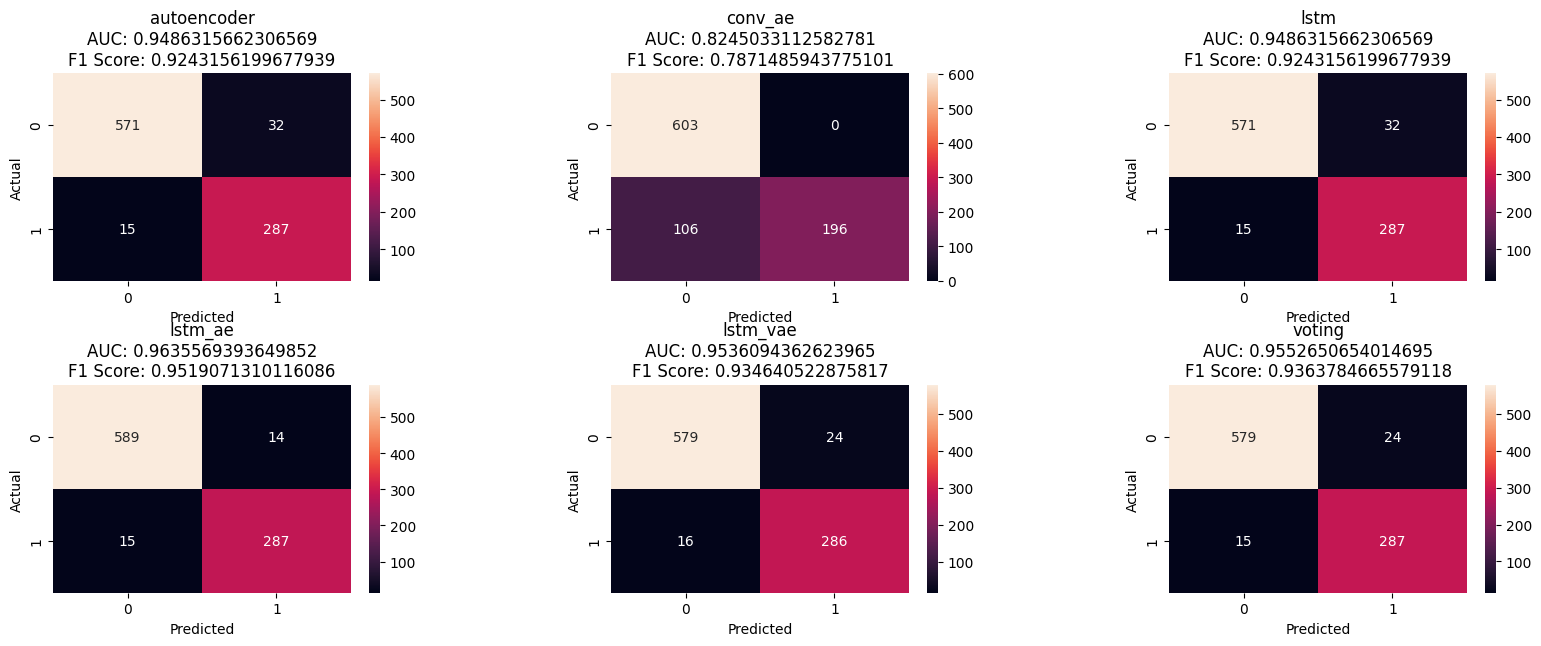
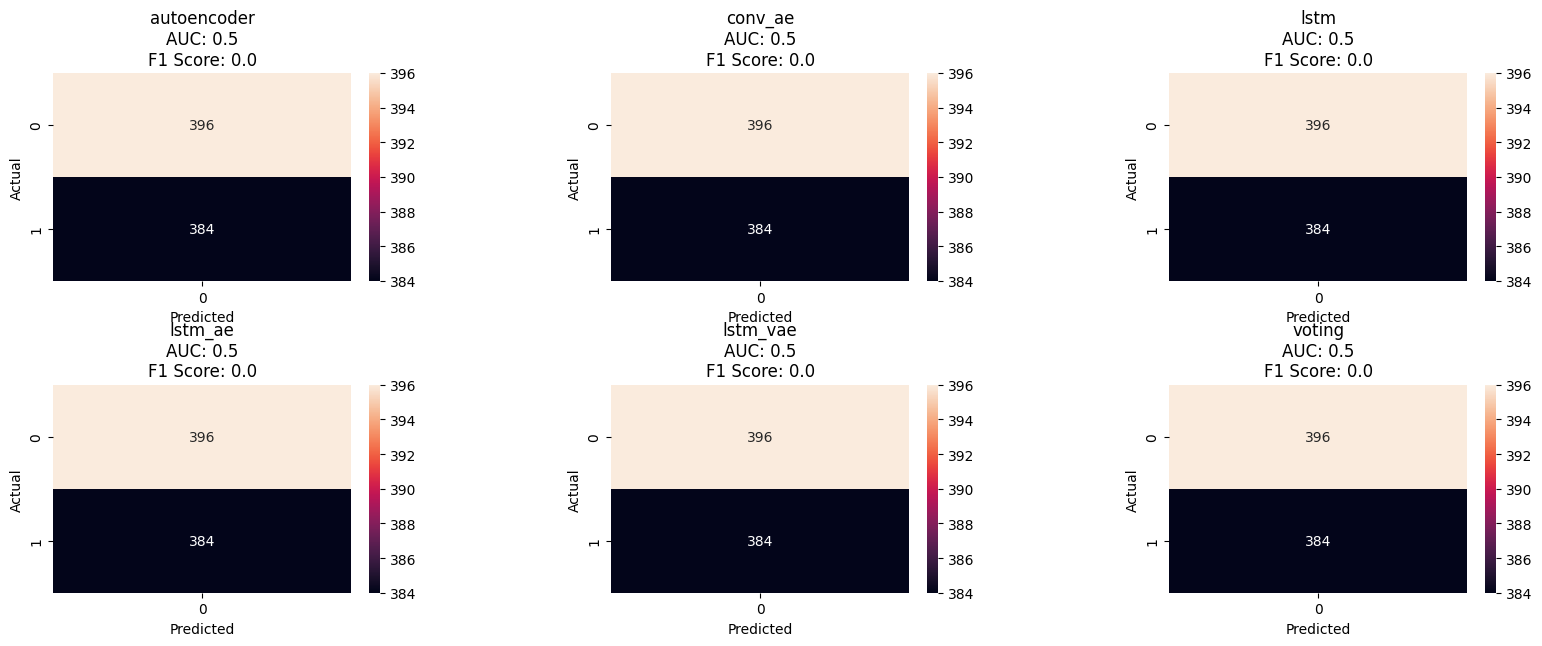
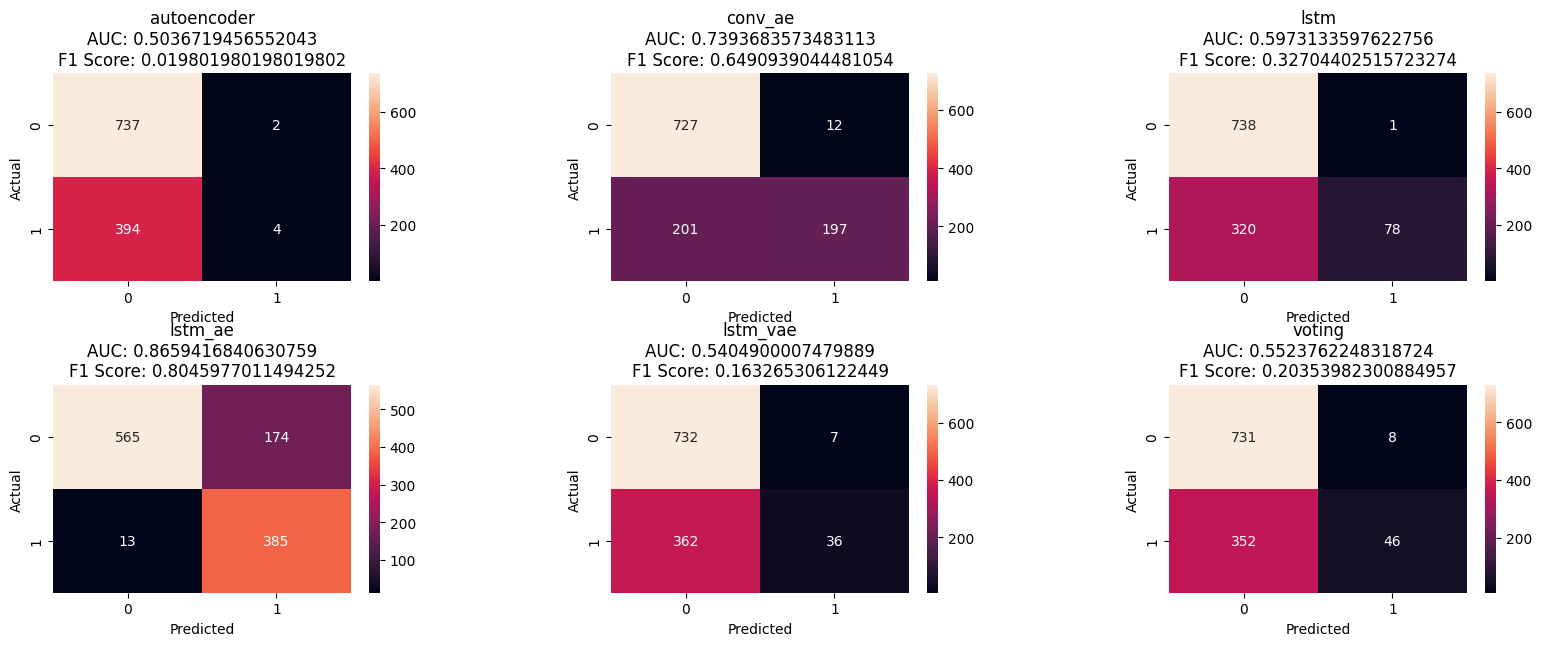
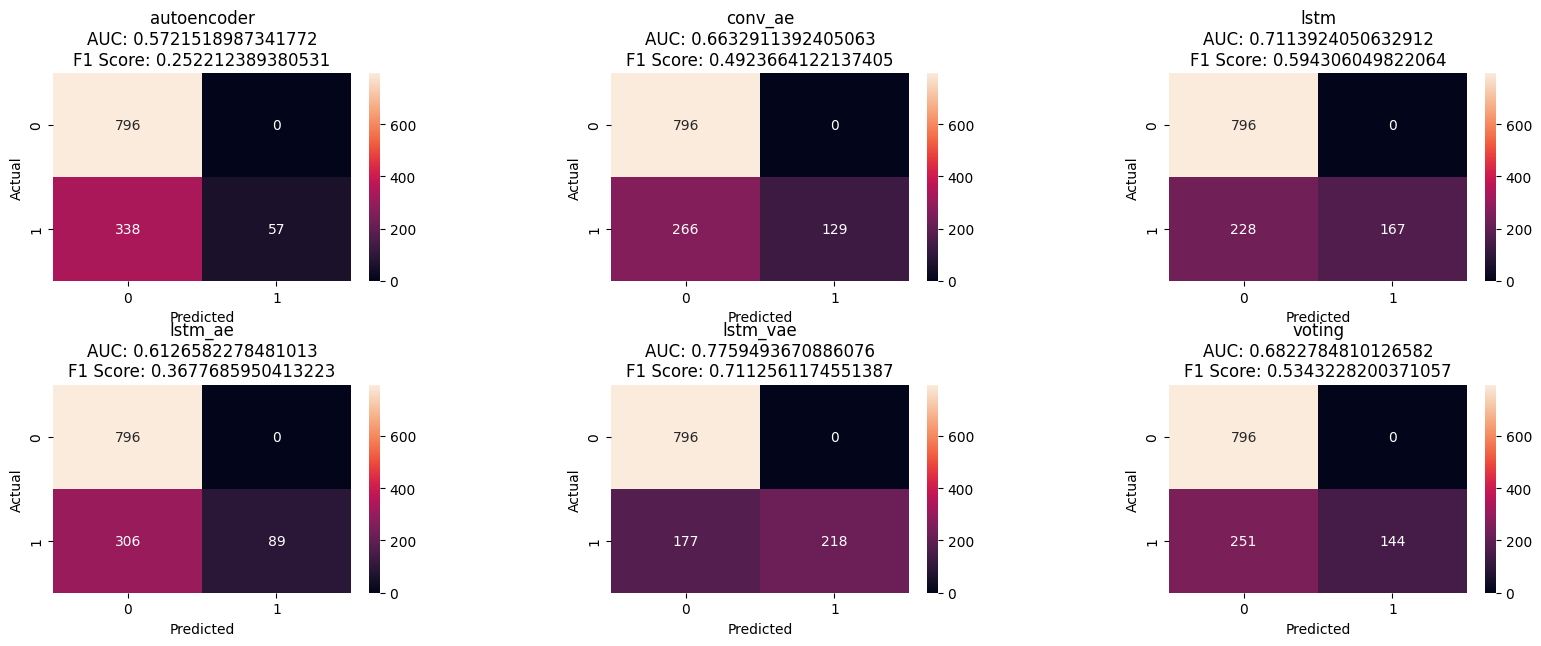
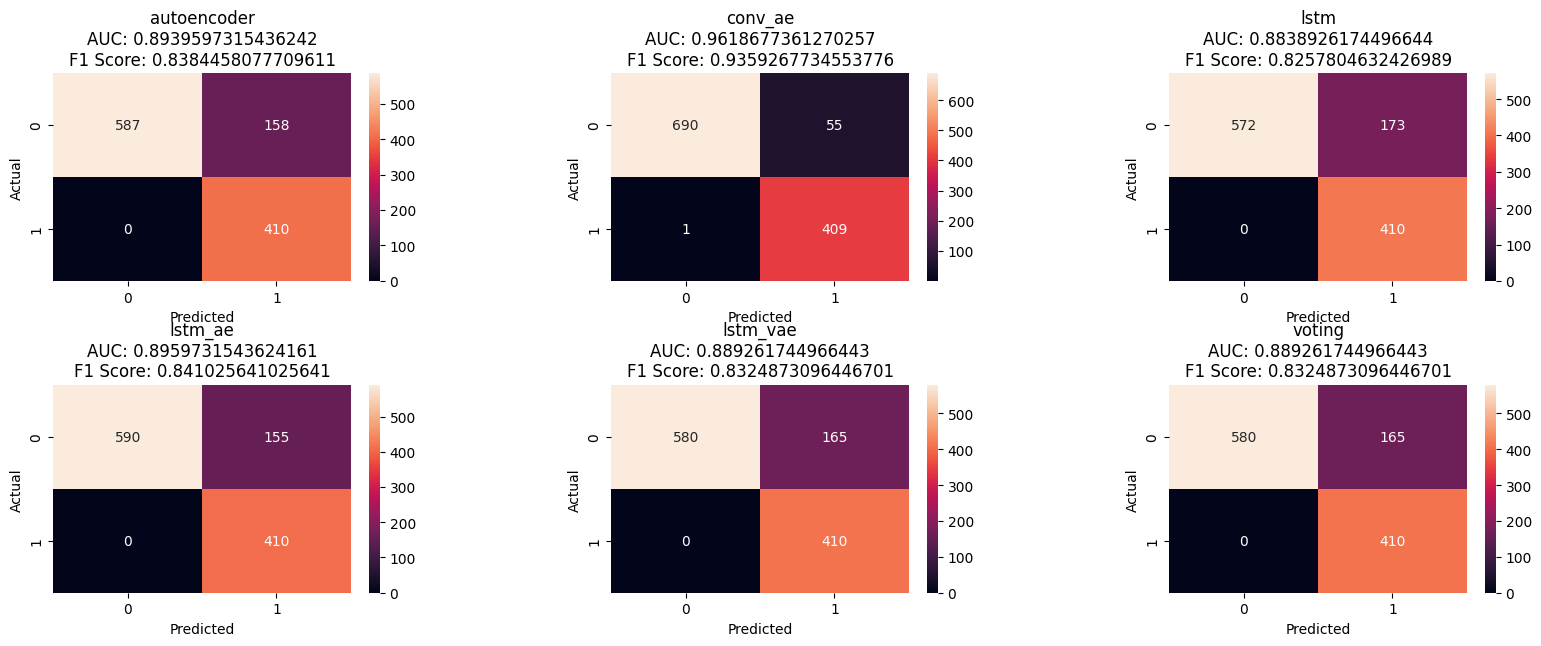
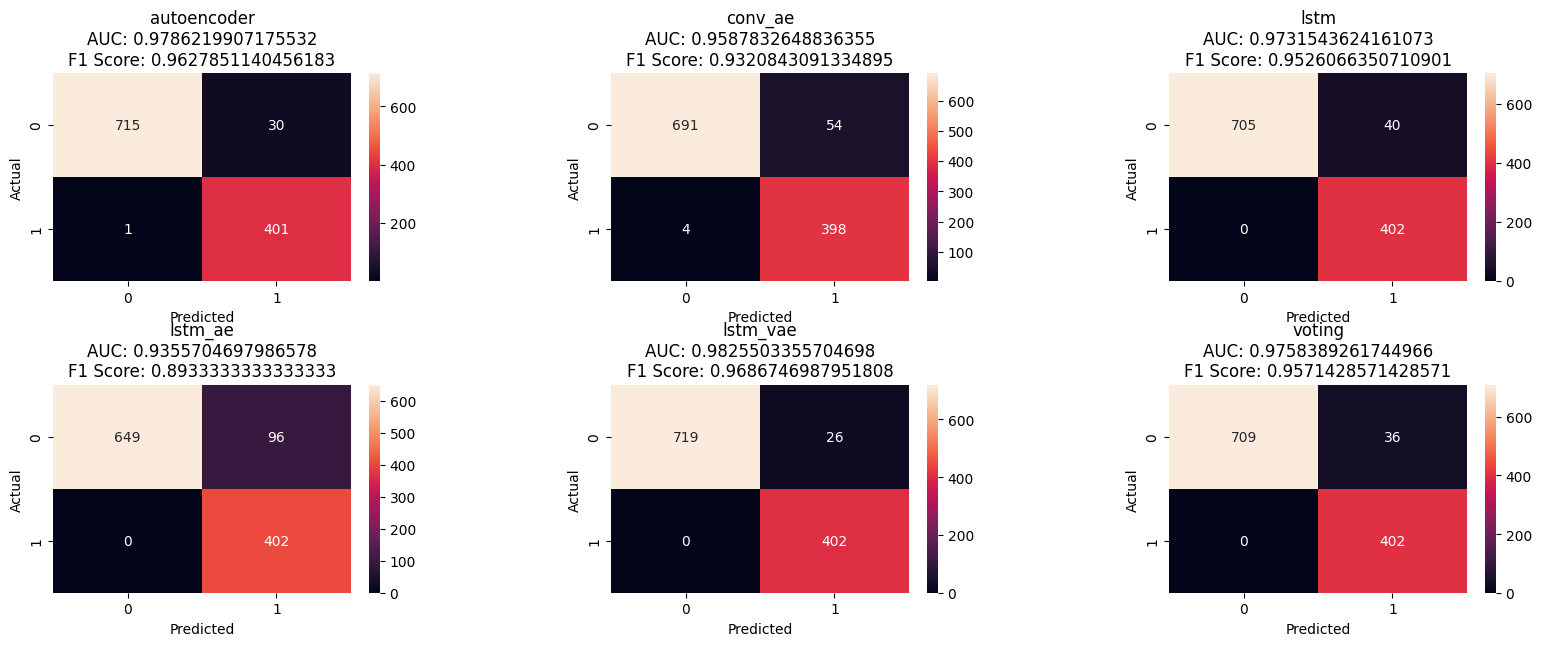
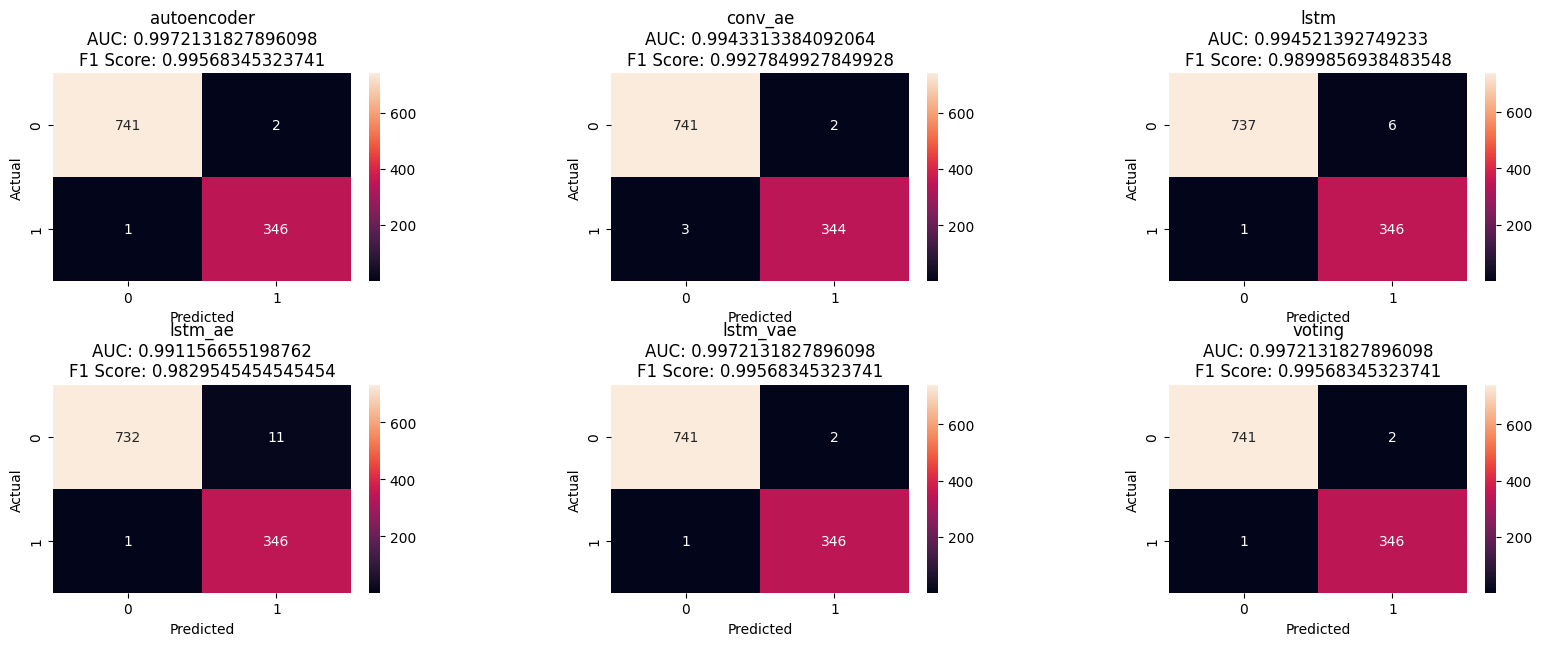
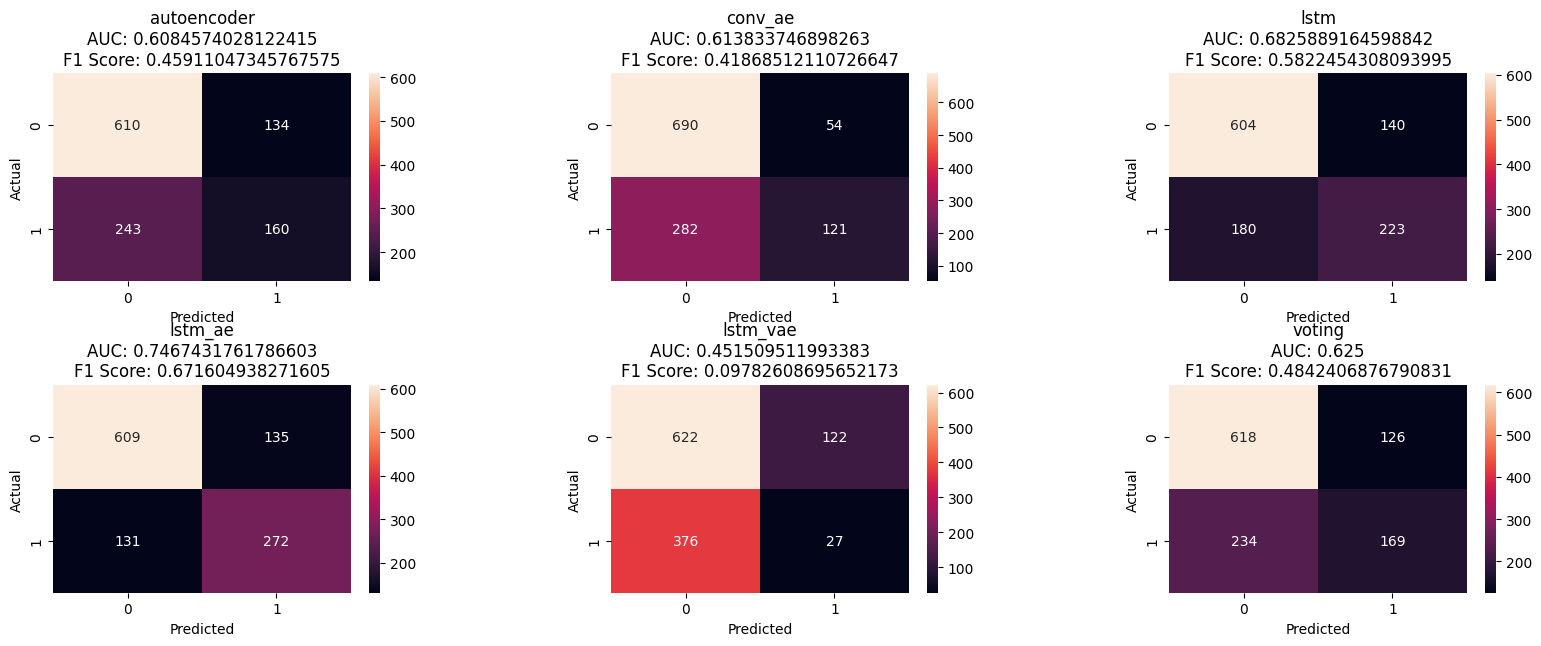
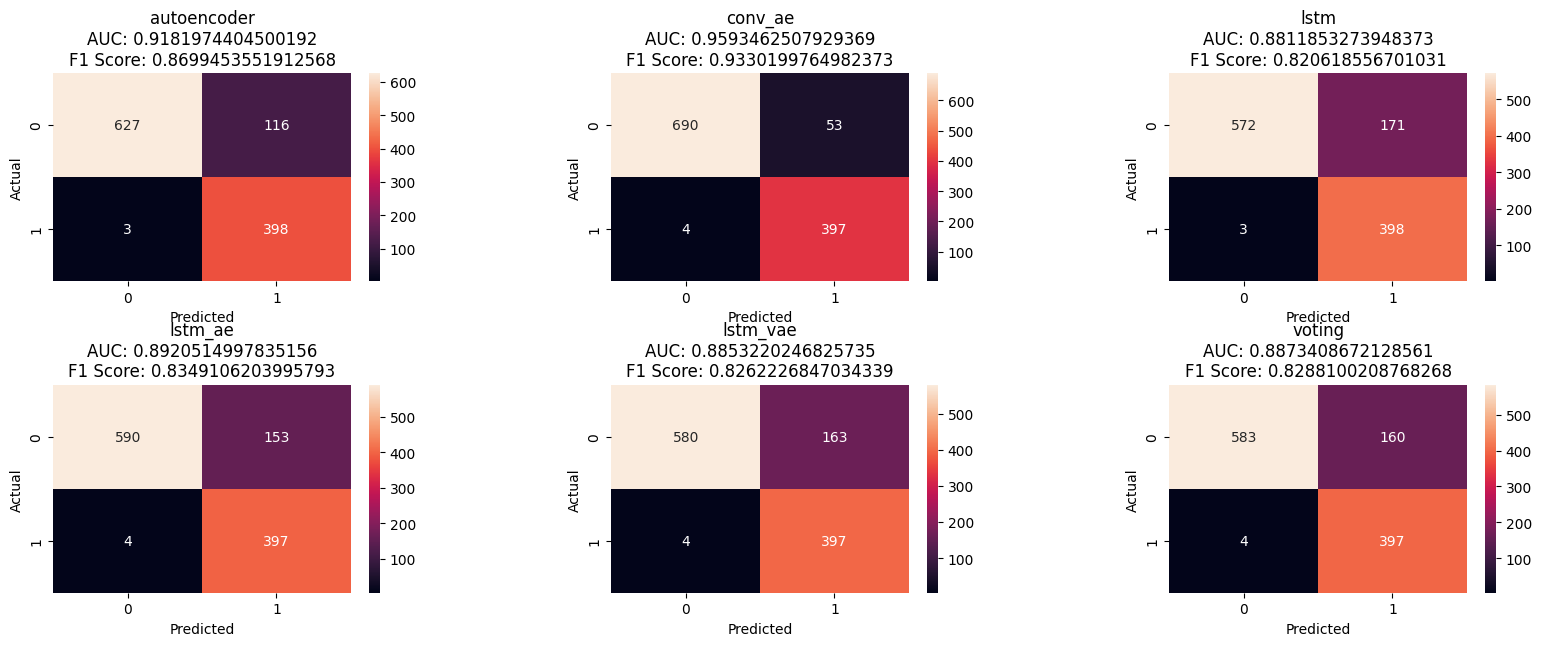
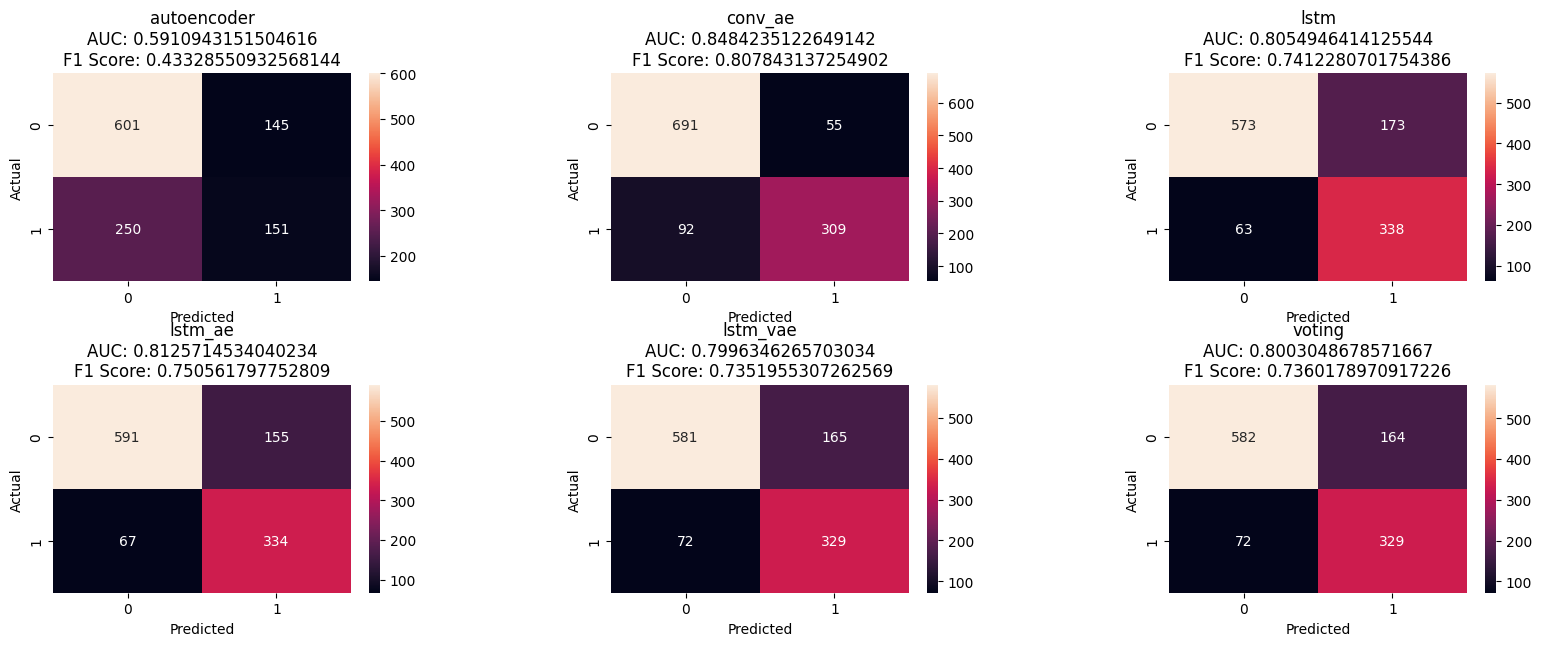
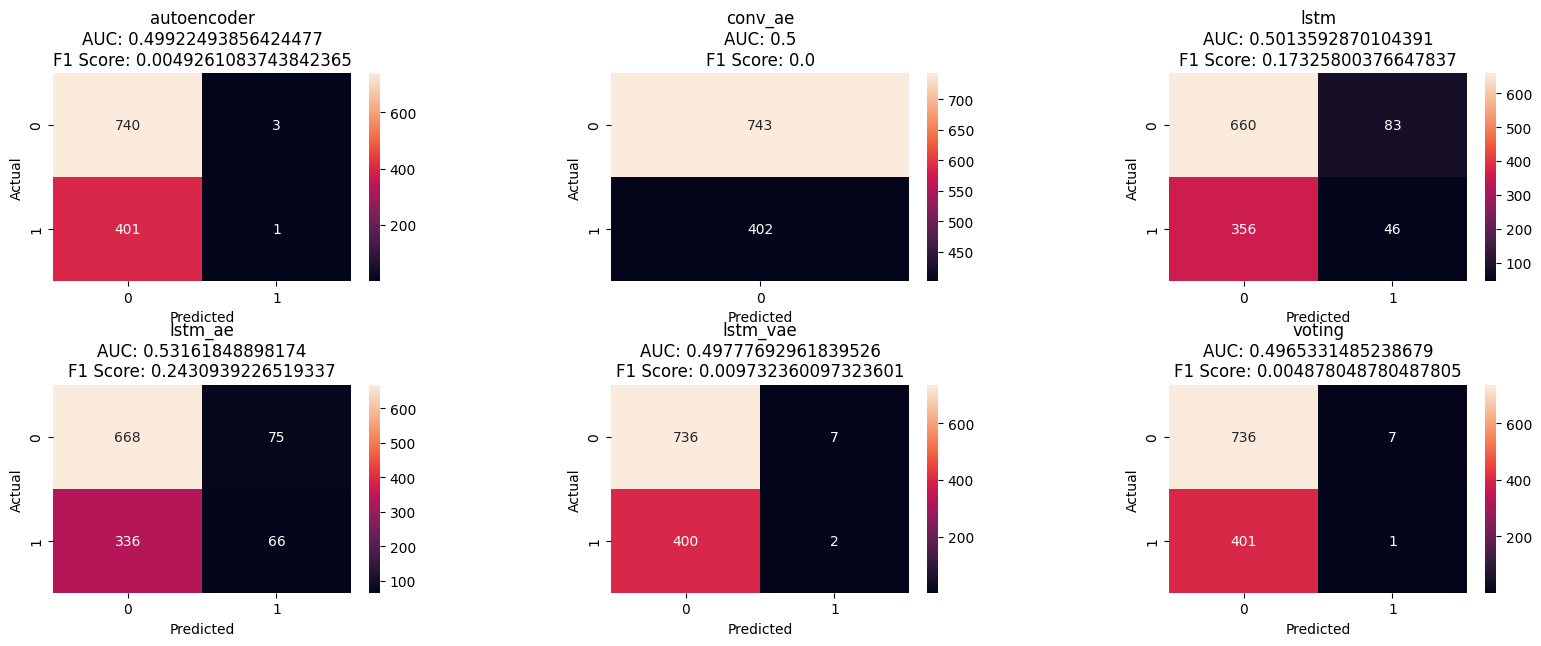
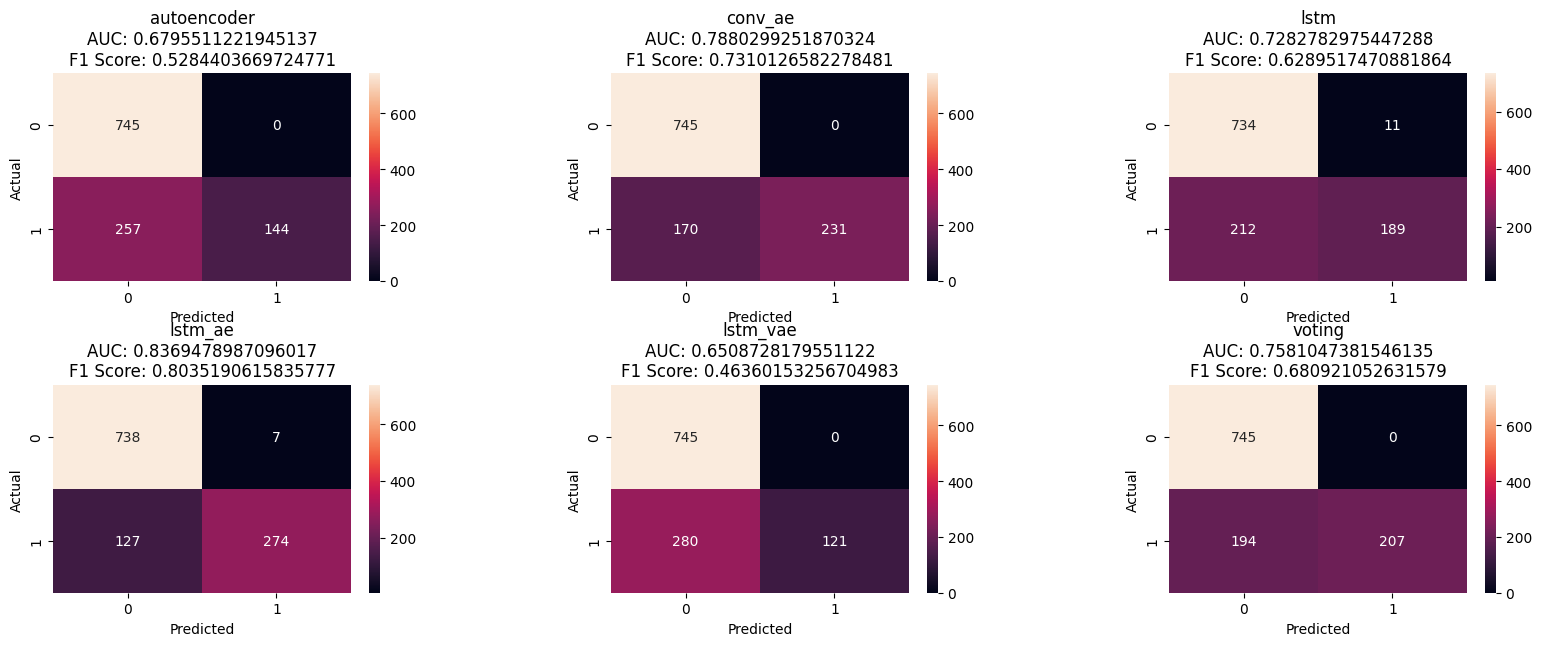
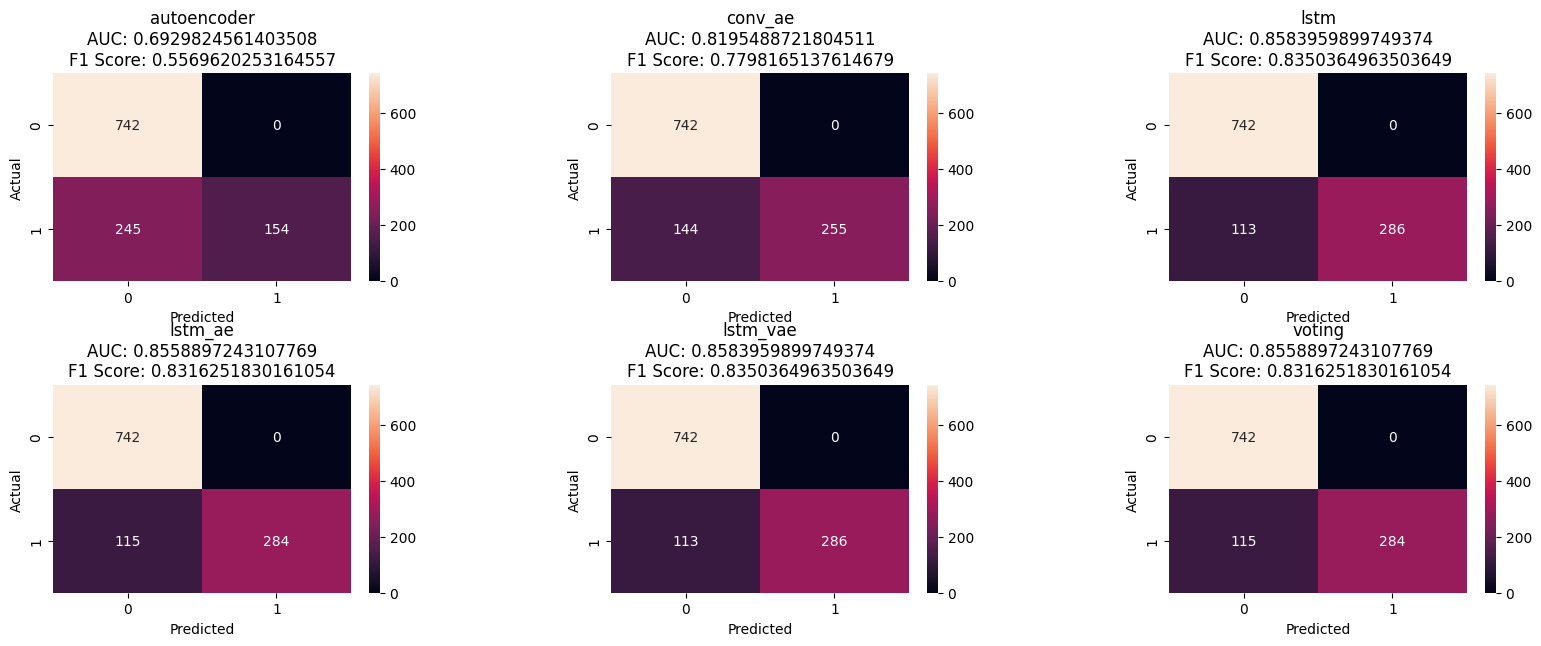
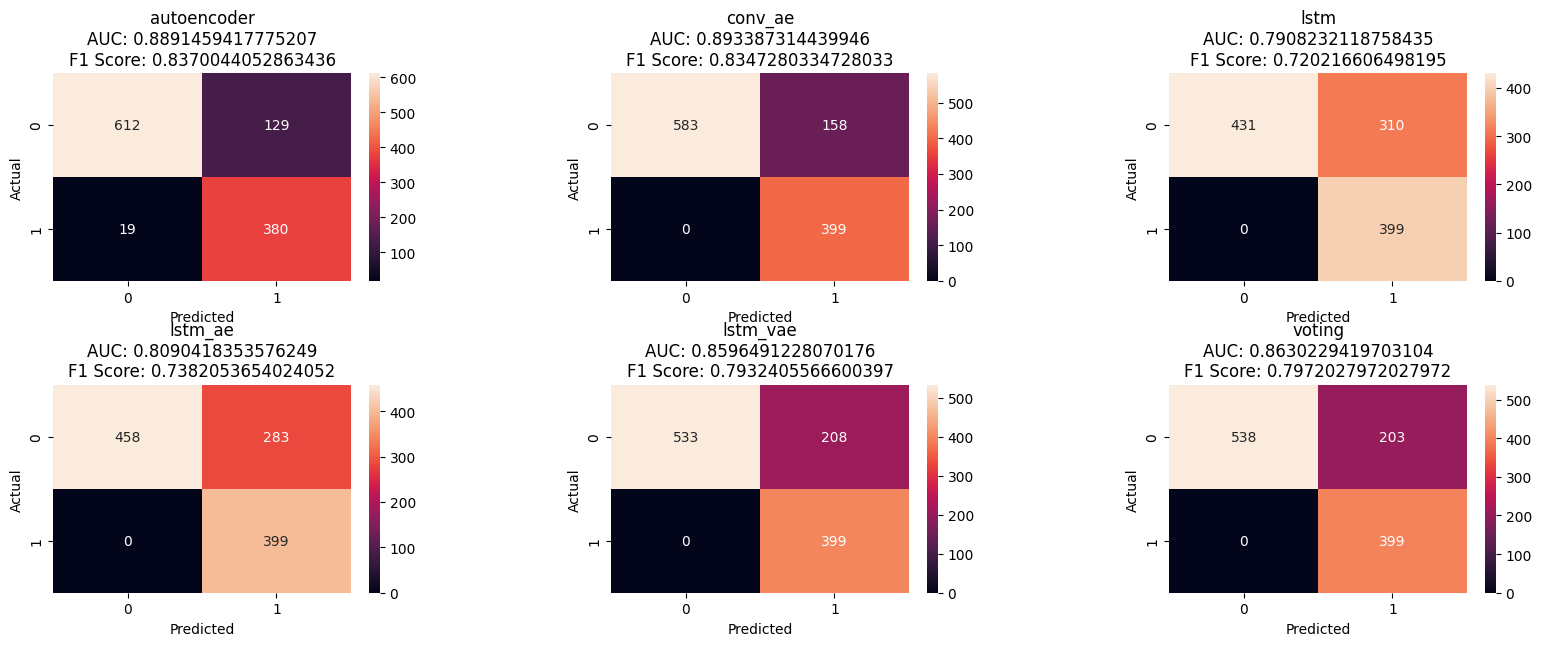
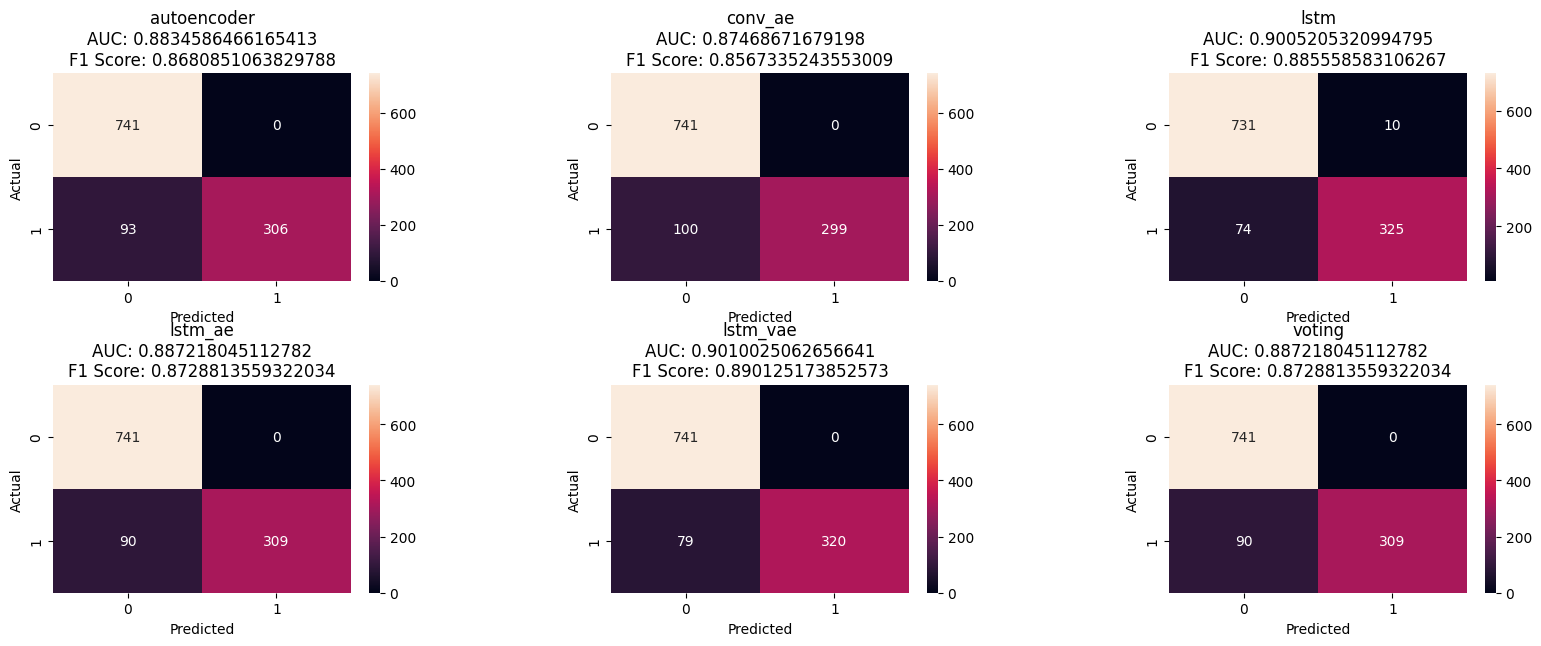
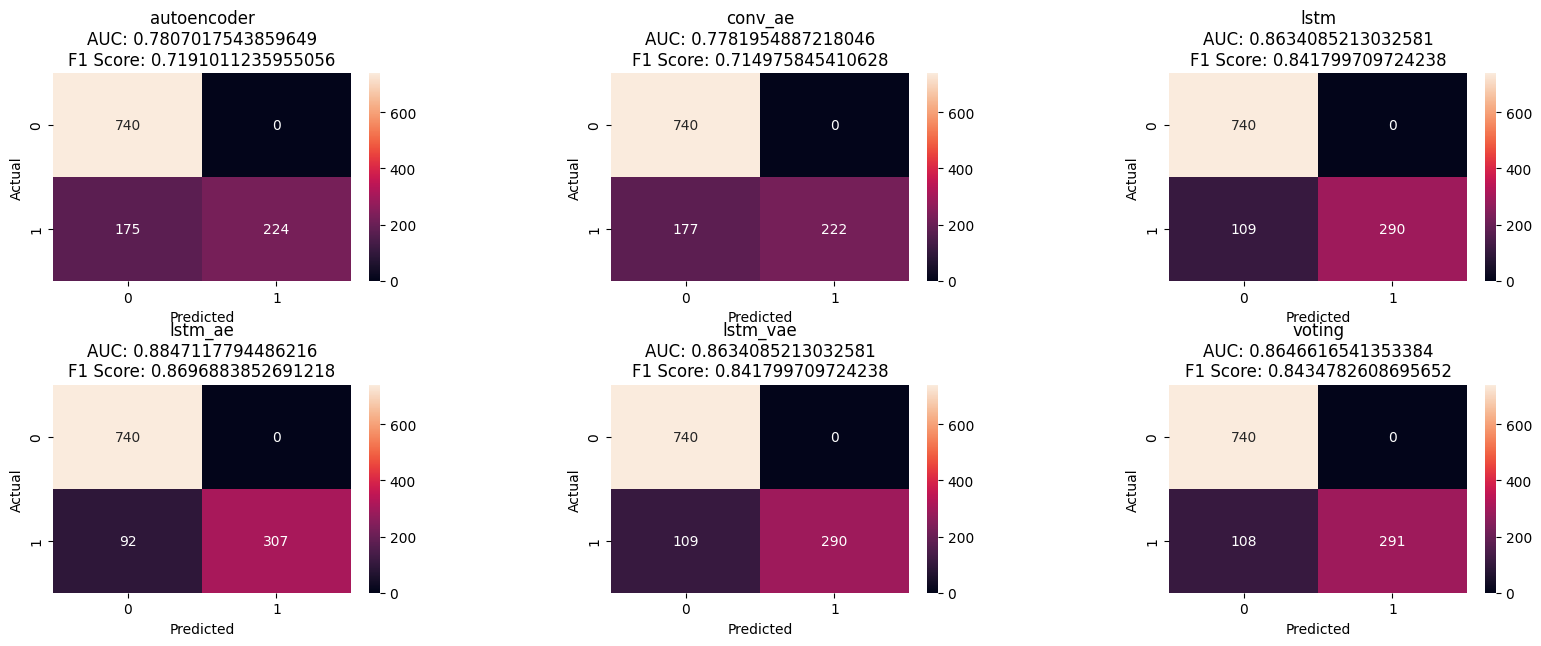
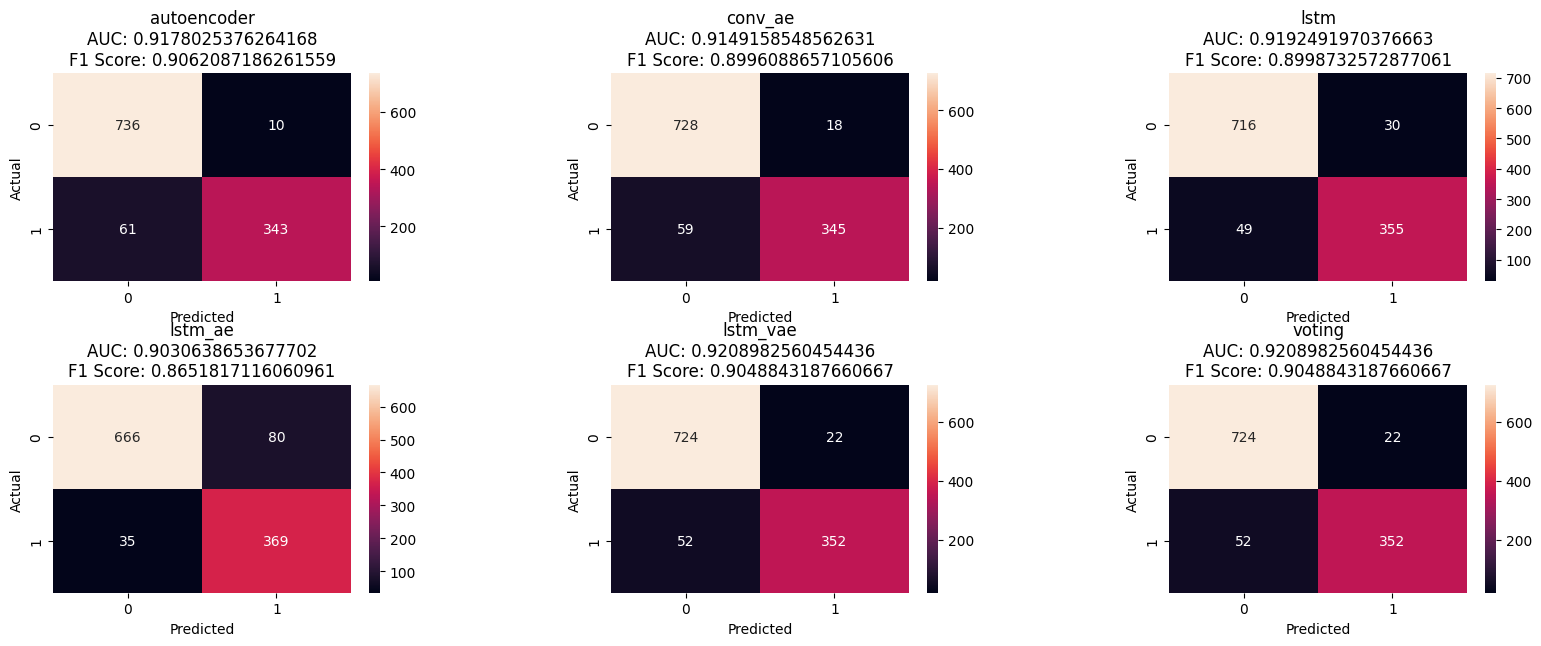
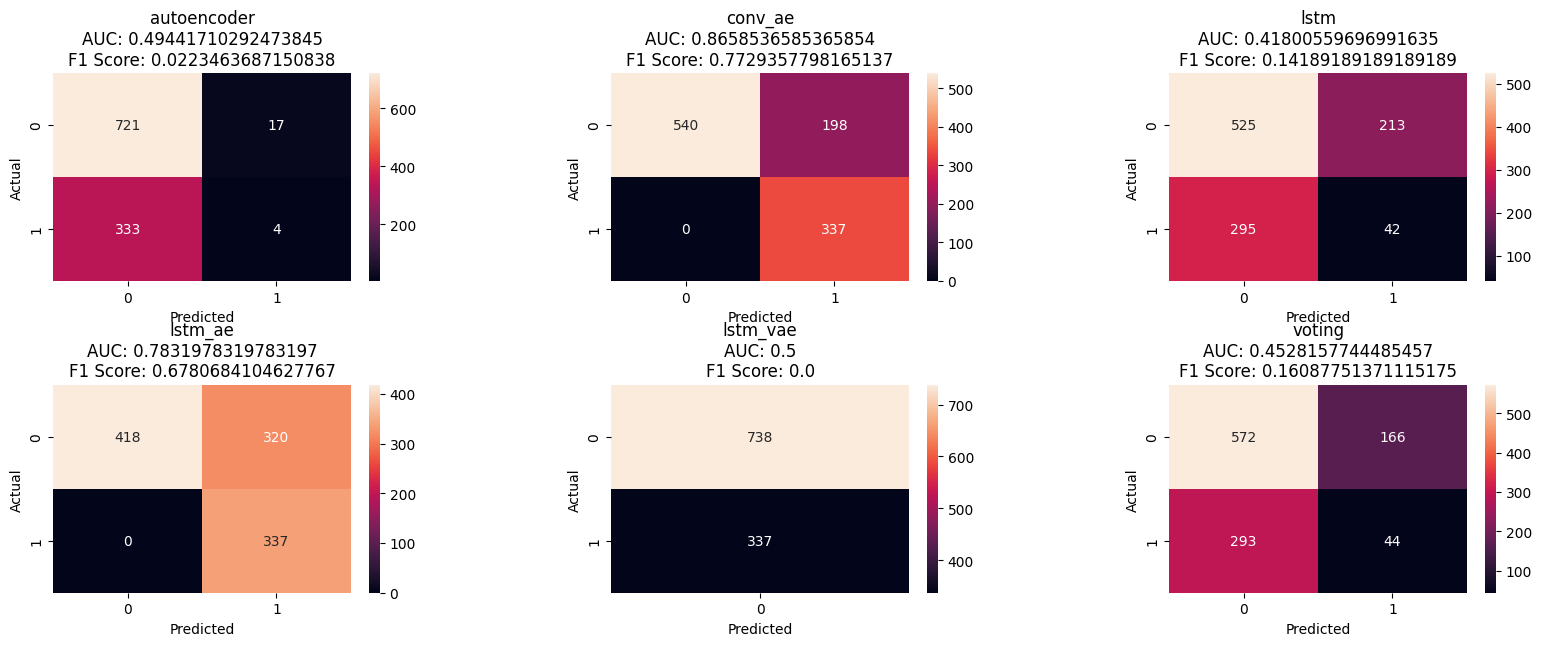
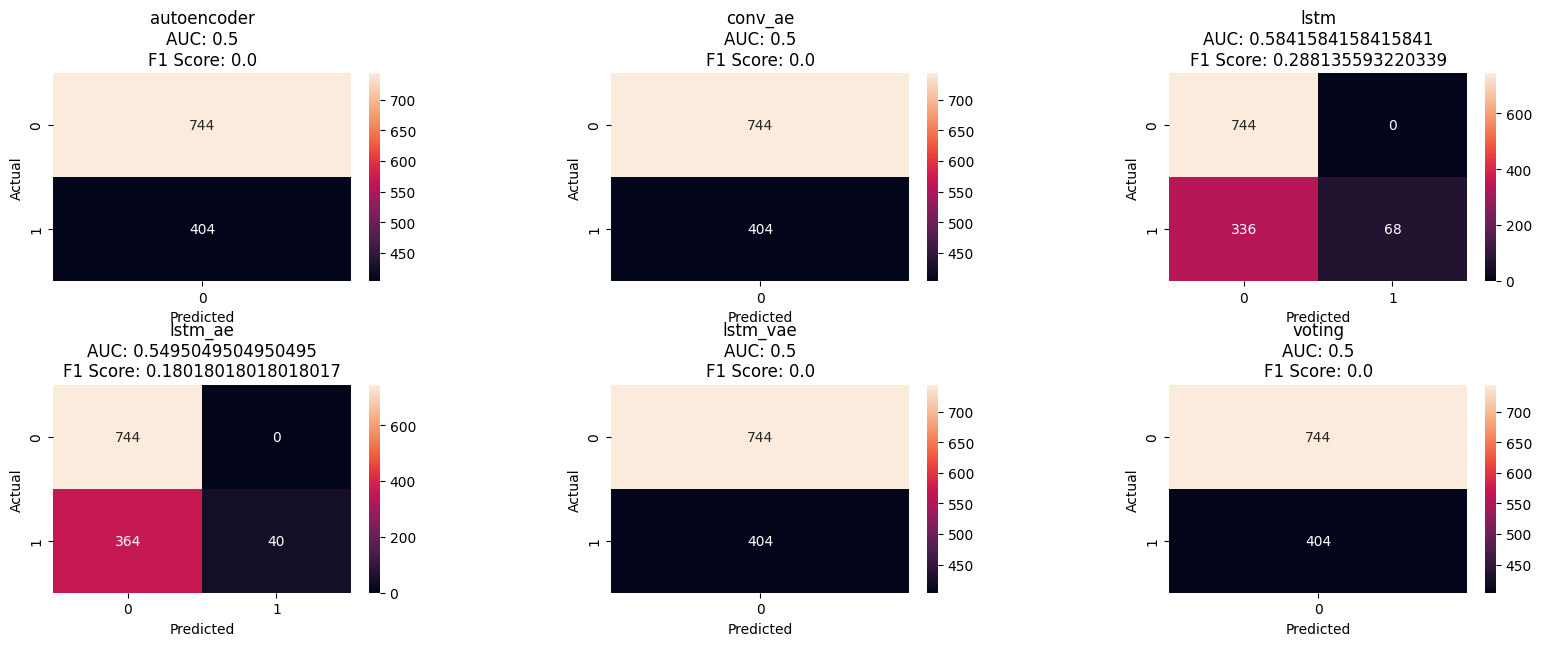
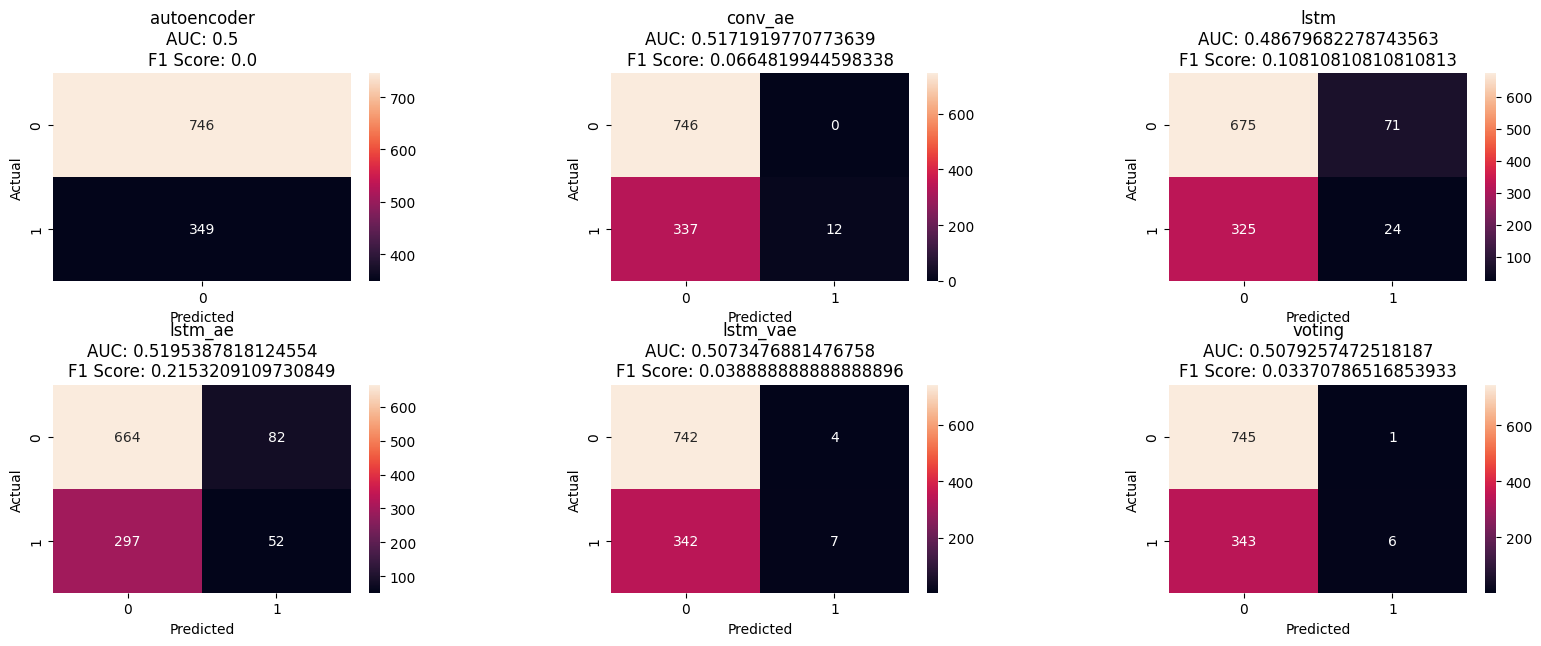
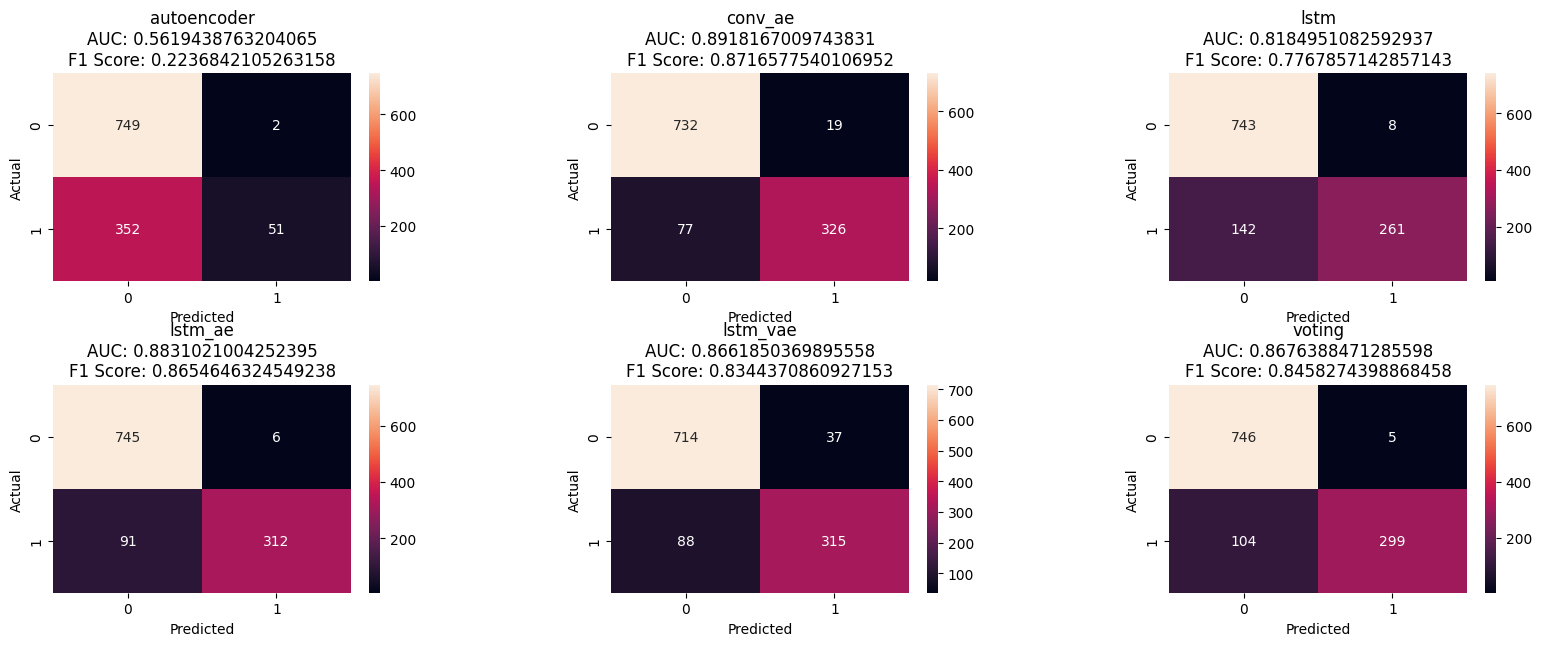
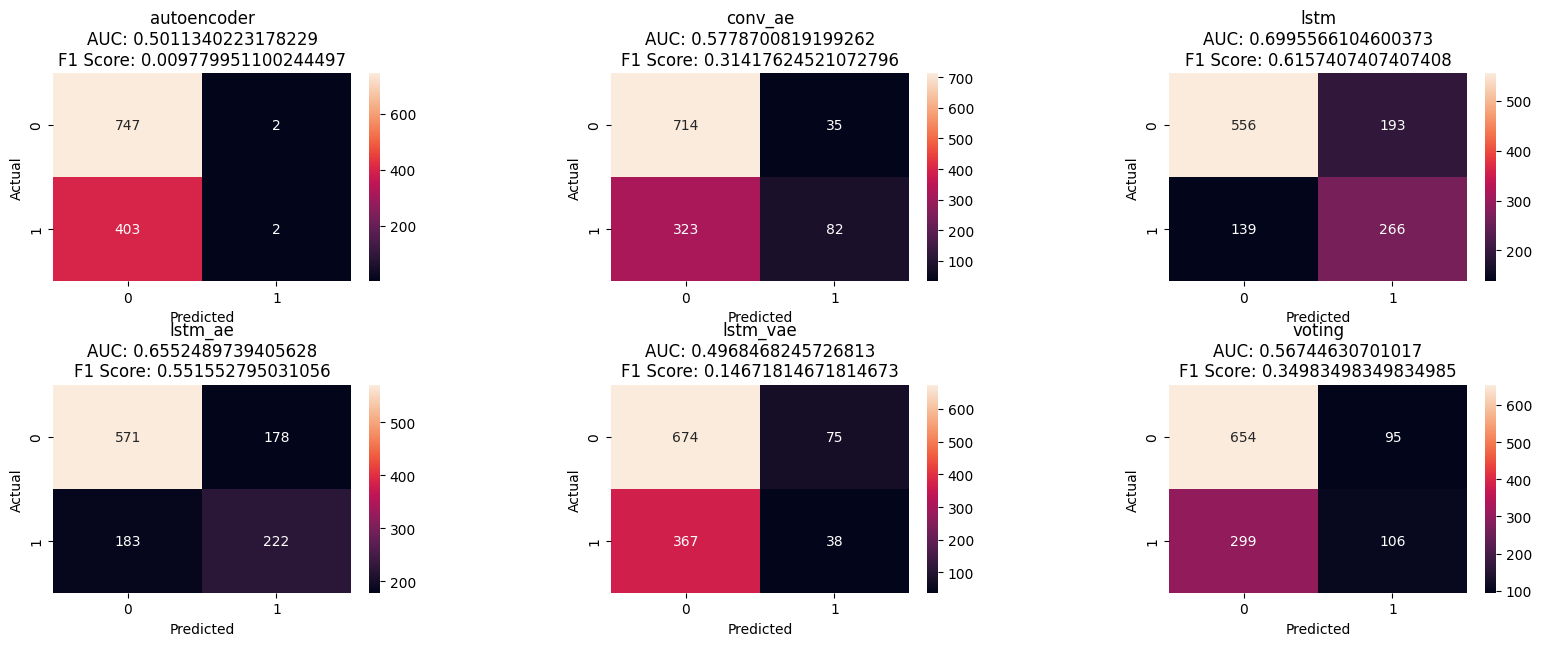
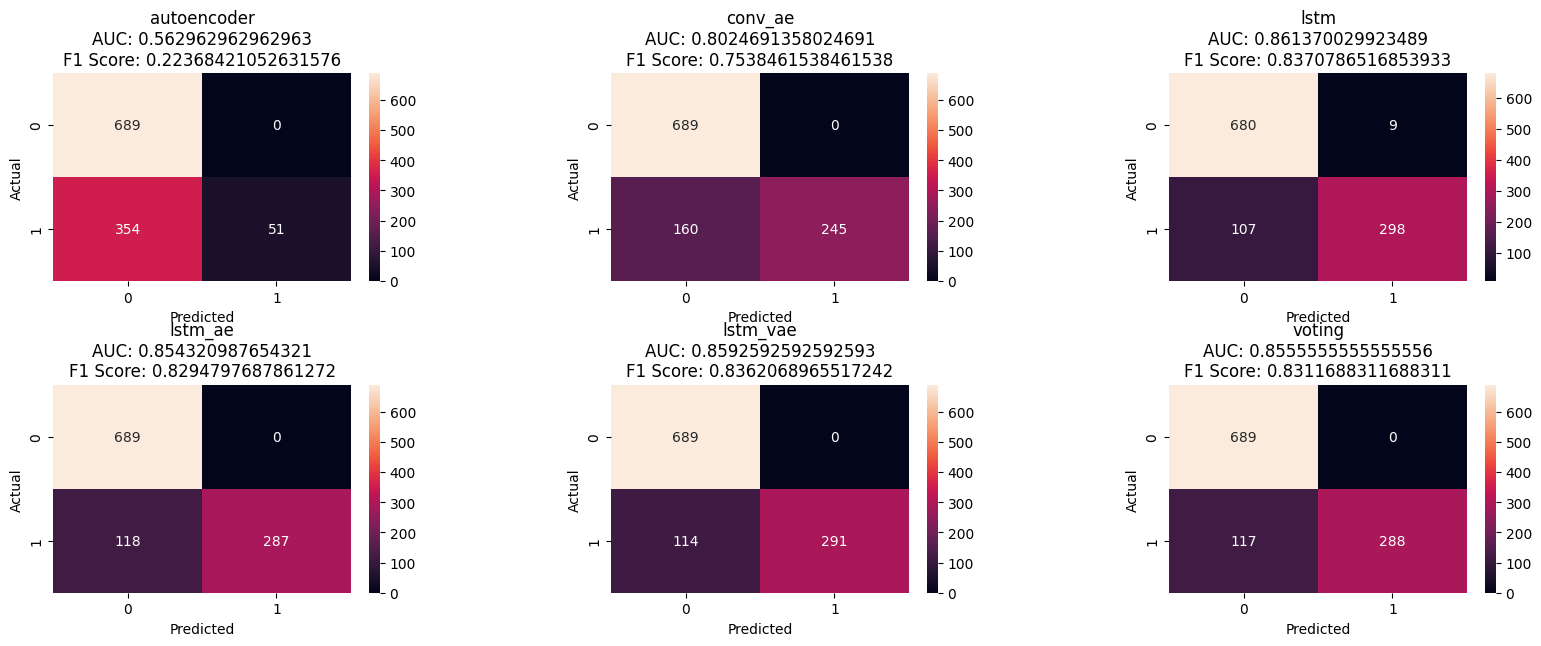
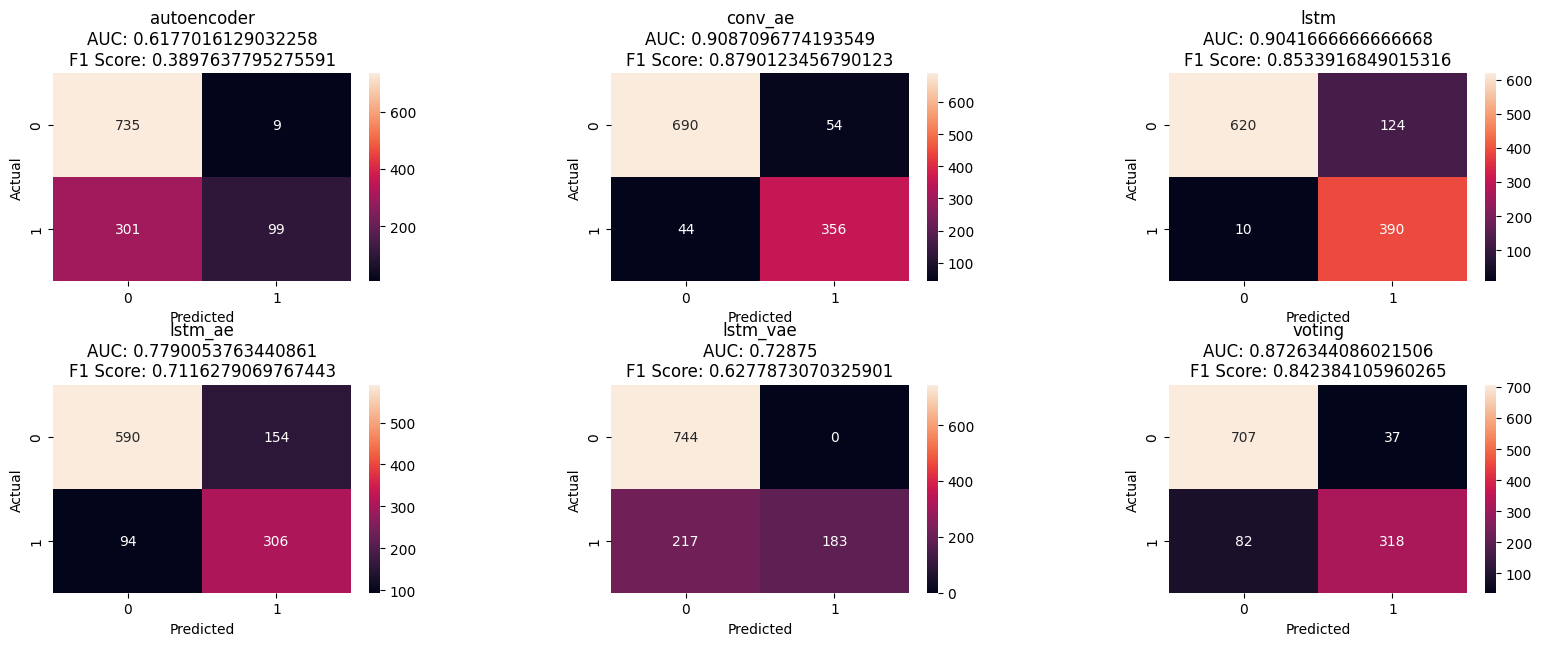
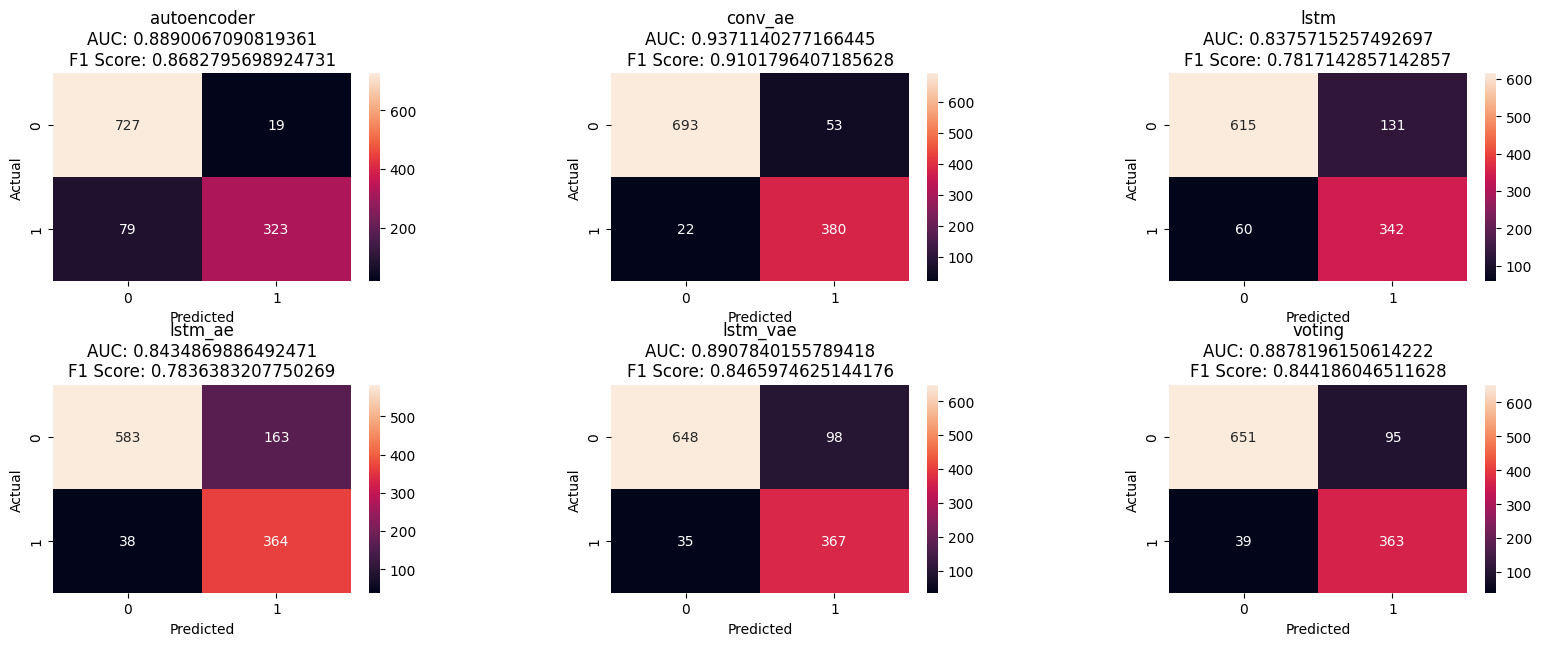
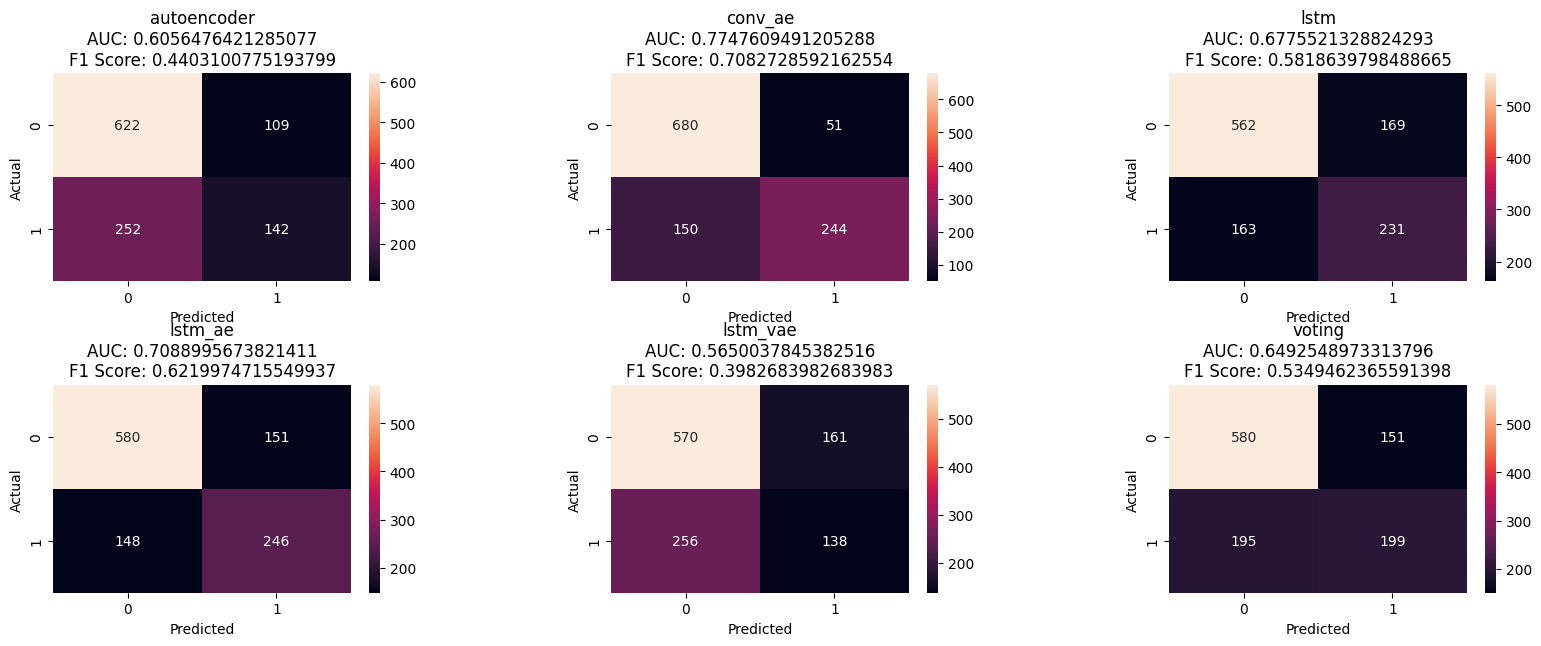
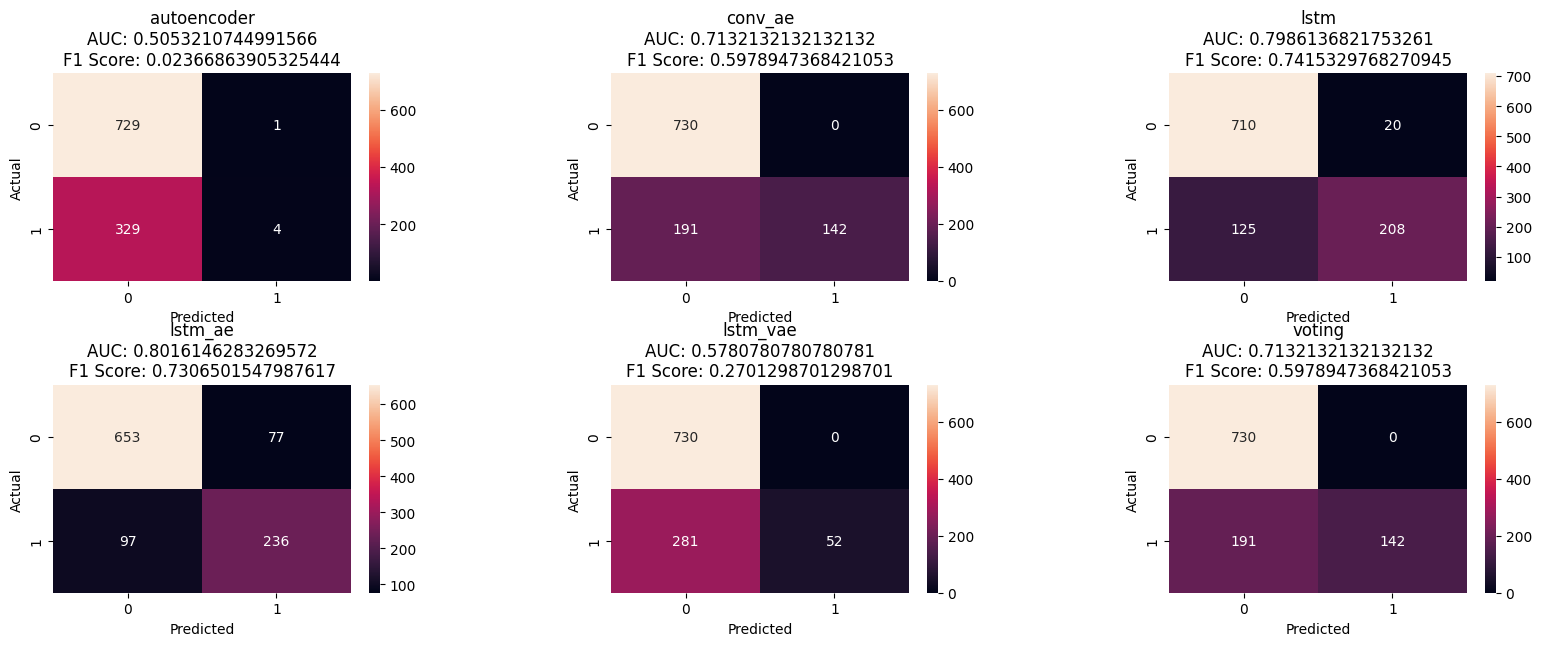
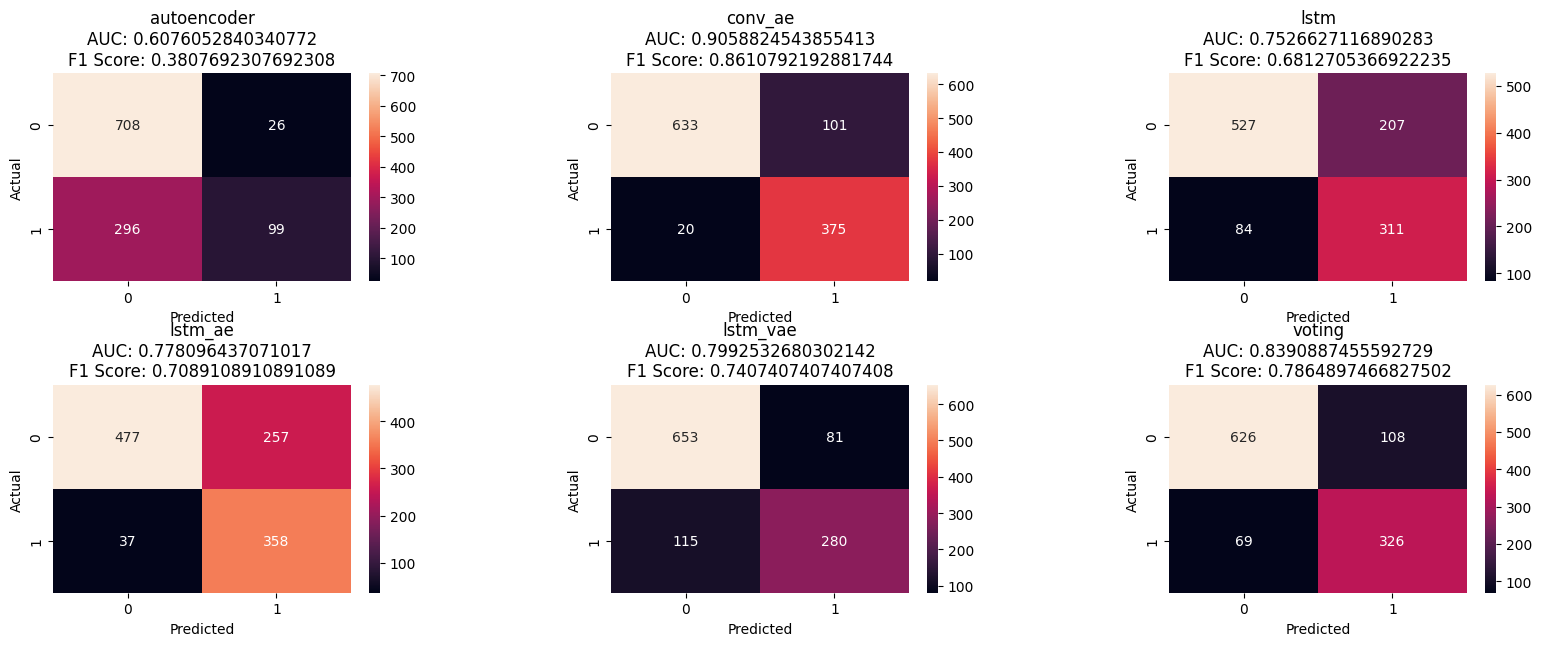
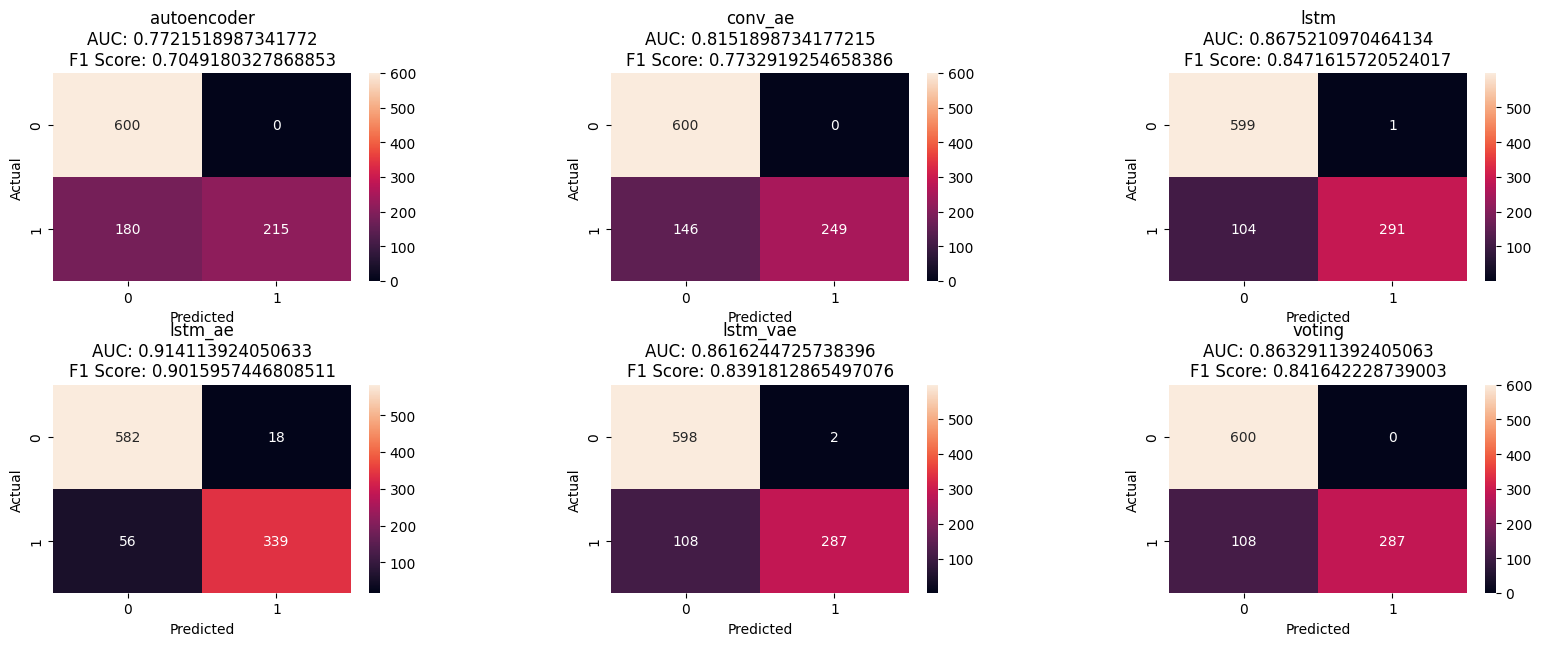

In [16]:
from IPython.display import HTML
import displayInfo
import pandas as pd

pd.set_option('display.max_colwidth', -1)
filename=[]
for i in range(0,34):
    filename.append(f"./images/{i}.png")

df = pd.DataFrame(data=filename, columns=["filename"])
df['image'] = df.filename.map(lambda f: displayInfo.get_thumbnail(f))

for i in range(0,12):
    df[f'image_A_{i}'] = "jasdjhasjdhjashdjhasd"

# display(df)
HTML(df[['filename', 'image', 'image_A_1','image_A_2','image_A_3','image_A_4']].to_html(formatters={'image': displayInfo.image_formatter}, escape=False))